In [1]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column


import numpy as np
from astropy.table import vstack
import torch

import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder, StandardScaler



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import numpy as np
from torch.distributions.normal import Normal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import ParameterGrid
import math
import copy
import warnings

from itertools import cycle

In [2]:
project_dir_path = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/"
temp_files_path = project_dir_path+'TempFiles/'


In [ ]:
# ============================================================
# REMOTE TRAINING CONFIGURATION
# ============================================================
RUN_REMOTE = False  # Set to True to run training on remote desktop

# Remote settings (only used if RUN_REMOTE=True)
REMOTE_HOST = "desktop-win"
REMOTE_USER = "cgw35"
REMOTE_BASE = "~/workspace"
REMOTE_REPO_PATH = f"{REMOTE_BASE}/TESS_Cluster_Age_ML"
REMOTE_CONDA_ENV = "ml"1
TMUX_SESSION_NAME = "hyperparam_training"

# Local directory for synced results from remote
REMOTE_RESULTS_DIR = project_dir_path + 'RemoteTempFiles/'

print(f"💻 Training Mode: {'REMOTE' if RUN_REMOTE else 'LOCAL'}")
if RUN_REMOTE:
    print(f"   Remote: {REMOTE_USER}@{REMOTE_HOST}")
    print(f"   Results will be synced to: {REMOTE_RESULTS_DIR}")

In [ ]:
# ============================================================
# REMOTE EXECUTION HELPER FUNCTIONS
# ============================================================
import subprocess
import os
from datetime import datetime

def sync_to_remote():
    """Rsync entire repo to remote desktop"""
    local_repo = "/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/"
    remote_dest = f"{REMOTE_USER}@{REMOTE_HOST}:{REMOTE_BASE}/"
    
    cmd = [
        "rsync", "-avz", "--progress",
        "--exclude", ".git",
        "--exclude", "*.ipynb_checkpoints",
        "--exclude", "__pycache__",
        "--exclude", "RemoteTempFiles",  # Don't sync remote results back
        local_repo, remote_dest
    ]
    print(f"🔄 Syncing repo to {REMOTE_HOST}...")
    print(f"   From: {local_repo}")
    print(f"   To: {remote_dest}")
    result = subprocess.run(cmd, check=True)
    print("✅ Sync to remote complete!")
    return result

def start_remote_training(params_grid_config):
    """Start training in tmux session on remote"""
    # Save params to a temporary config file that the remote script will read
    import pickle
    config_file = temp_files_path + 'remote_config.pkl'
    with open(config_file, 'wb') as f:
        pickle.dump(params_grid_config, f)
    
    print(f"📝 Saved parameter grid config to {config_file}")
    
    # Sync just the config file to remote
    print(f"🔄 Syncing config file to remote...")
    subprocess.run([
        "rsync", "-avz", config_file,
        f"{REMOTE_USER}@{REMOTE_HOST}:{REMOTE_REPO_PATH}/GaussianNN_CGW/Model_Pipeline/TempFiles/"
    ], check=True)
    
    # Construct remote command
    remote_cmd = (
        f"cd {REMOTE_REPO_PATH}/GaussianNN_CGW/Model_Pipeline && "
        f"conda activate {REMOTE_CONDA_ENV} && "
        f"python run_hyperparam_training.py 2>&1 | tee TempFiles/logs/training_$(date +%Y%m%d_%H%M%S).log"
    )
    
    # Start in tmux
    tmux_cmd = f"tmux new-session -d -s {TMUX_SESSION_NAME} '{remote_cmd}'"
    ssh_cmd = ["ssh", f"{REMOTE_USER}@{REMOTE_HOST}", tmux_cmd]
    
    print(f"🚀 Starting remote training in tmux session '{TMUX_SESSION_NAME}'...")
    subprocess.run(ssh_cmd, check=True)
    print(f"✅ Training started on remote!")
    print(f"\n📊 Use monitoring functions to track progress (see cells below)")

def check_remote_status():
    """Check if remote training is still running"""
    print(f"🔍 Checking remote training status...")
    cmd = ["ssh", f"{REMOTE_USER}@{REMOTE_HOST}", 
           f"tmux ls 2>/dev/null | grep {TMUX_SESSION_NAME} || echo 'Session not found'"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if "Session not found" in result.stdout:
        print("❌ Training session not running (completed or failed)")
        print("   Run sync_results_back() to retrieve results")
        return False
    else:
        print(f"✅ Training session '{TMUX_SESSION_NAME}' is active")
        print(result.stdout)
        return True

def tail_remote_output(lines=50):
    """View recent training output from tmux session"""
    print(f"📋 Fetching last {lines} lines of output...")
    cmd = ["ssh", f"{REMOTE_USER}@{REMOTE_HOST}",
           f"tmux capture-pane -t {TMUX_SESSION_NAME} -p | tail -n {lines}"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    print("="*70)
    print(result.stdout)
    print("="*70)

def tail_remote_log(lines=50):
    """View recent training log from the log file"""
    print(f"📋 Fetching last {lines} lines of log file...")
    cmd = ["ssh", f"{REMOTE_USER}@{REMOTE_HOST}",
           f"ls -t {REMOTE_REPO_PATH}/GaussianNN_CGW/Model_Pipeline/TempFiles/logs/training_*.log | head -n 1 | xargs tail -n {lines}"]
    result = subprocess.run(cmd, capture_output=True, text=True)
    print("="*70)
    print(result.stdout)
    print("="*70)

def sync_results_back():
    """Sync training results from remote back to local"""
    os.makedirs(REMOTE_RESULTS_DIR, exist_ok=True)
    
    remote_src = f"{REMOTE_USER}@{REMOTE_HOST}:{REMOTE_REPO_PATH}/GaussianNN_CGW/Model_Pipeline/TempFiles/ModelGridLogs/"
    local_dest = REMOTE_RESULTS_DIR
    
    cmd = ["rsync", "-avz", "--progress", remote_src, local_dest]
    print(f"🔄 Syncing results from {REMOTE_HOST}...")
    print(f"   From: {remote_src}")
    print(f"   To: {local_dest}")
    subprocess.run(cmd, check=True)
    print(f"✅ Results synced to {local_dest}")
    
    # List available result files
    import glob
    result_files = glob.glob(os.path.join(REMOTE_RESULTS_DIR, "*.pkl"))
    if result_files:
        print(f"\n📁 Available result files:")
        for f in sorted(result_files, reverse=True):
            size_mb = os.path.getsize(f) / (1024*1024)
            print(f"   - {os.path.basename(f)} ({size_mb:.2f} MB)")
    return result_files

def load_remote_results(filename=None):
    """
    Load training results from RemoteTempFiles/
    
    Args:
        filename: Specific file to load. If None, loads the most recent file.
    """
    import pickle
    import glob
    
    if filename is None:
        # Find most recent file
        result_files = glob.glob(os.path.join(REMOTE_RESULTS_DIR, "training_results_*.pkl"))
        if not result_files:
            print(f"❌ No result files found in {REMOTE_RESULTS_DIR}")
            return None
        filepath = max(result_files, key=os.path.getmtime)
        print(f"📂 Loading most recent results: {os.path.basename(filepath)}")
    else:
        filepath = os.path.join(REMOTE_RESULTS_DIR, filename)
        print(f"📂 Loading: {filename}")
    
    with open(filepath, 'rb') as f:
        results = pickle.load(f)
    
    print(f"✅ Results loaded successfully!")
    return results

def attach_remote_instructions():
    """Print instructions for manually attaching to remote tmux session"""
    print("="*70)
    print("🖥️  MANUAL REMOTE ACCESS INSTRUCTIONS")
    print("="*70)
    print(f"To attach to the remote training session:")
    print(f"\n  1. SSH to remote:")
    print(f"     ssh {REMOTE_USER}@{REMOTE_HOST}")
    print(f"\n  2. Attach to tmux session:")
    print(f"     tmux attach -t {TMUX_SESSION_NAME}")
    print(f"\n  3. Detach from tmux (without stopping training):")
    print(f"     Press: Ctrl+b, then d")
    print(f"\n  4. View log file directly:")
    print(f"     tail -f ~/workspace/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/TempFiles/logs/training_*.log")
    print("="*70)

print("✅ Remote execution helper functions loaded!")
print("   - sync_to_remote()")
print("   - start_remote_training(params)")
print("   - check_remote_status()")
print("   - tail_remote_output(lines=50)")
print("   - tail_remote_log(lines=50)")
print("   - sync_results_back()")
print("   - load_remote_results(filename=None)")
print("   - attach_remote_instructions()")

# LOAD THE DATA

In [3]:
import pickle

save_path = temp_files_path
file_name = 'traintest_data4.pkl'

with open(save_path+file_name, 'rb') as f:
    PROCESSED_DATASET = pickle.load(f)

(   X_train, X_test, 
    period_train, period_test, 
    y_train, y_test, 
    feature_cols,
    train_cluster_names, test_cluster_names) = PROCESSED_DATASET


print("X_train: ", np.shape(X_train))
print("X_test: ", np.shape(X_test))
print("period_train: ", np.shape(period_train))
print("period_test: ", np.shape(period_test))
print("y_train: ", np.shape(y_train))
print("y_test: ", np.shape(y_test))
print("feature_cols: ", feature_cols)
print("\n⚠️  NOTE: Data is RAW (unscaled). Preprocessing will be done per-fold to prevent data leakage.")

X_train:  torch.Size([3972, 17])
X_test:  torch.Size([436, 17])
period_train:  torch.Size([3972, 1089])
period_test:  torch.Size([436, 1089])
y_train:  torch.Size([3972, 1])
y_test:  torch.Size([436, 1])
feature_cols:  ['rms', 'std', 'MAD', 'sigmaG', 'skewness', 'von_neumann_ratio', 'J_Stetson', 'max_power', 'freq_at_max_power', 'ratio_of_power_at_high_v_low_freq', 'max_autocorrelation', 'time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power', 'SumLSP_7_4_Day_Power', 'SumLSP_4_1_Day_Power', 'SumLSP_1_p5_Day_Power', 'Entropy']

⚠️  NOTE: Data is RAW (unscaled). Preprocessing will be done per-fold to prevent data leakage.


In [4]:
# Full histogram illustrating the data:
import sys
sys.path.append(project_dir_path+'HelperFcns/')


from VisualizeDataset import visualize_feature_distributions, visualize_mass_bin_distribution
from VisualizeDataset import visualize_summary_stats, plot_correlation_matrix

visualize=False
if visualize:
    #visualize_feature_distributions(X_train, feature_cols)
    visualize_mass_bin_distribution(y_train, y_test)
    visualize_summary_stats(X_train, y_train, feature_cols)
    plot_correlation_matrix(X_train, feature_names=feature_cols, figsize=(14, 11), annot=True)
    #plot_correlation_matrix(period_train, feature_names=None, figsize=(14, 11), annot=False)


# Define The NN Model

In [5]:
# Load in yt datasets
import sys
sys.path.append(project_dir_path)

from GaussianNN_wPeriodogram import DualInputNN

# Load in all the training functions and helper functions

In [6]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

# Import training functions from helper file
import sys
sys.path.append(project_dir_path)

from Training_HelperFcns import (
    GaussianNLLLoss_ME, 
    sanitize_batch,
    Run_Single_Batch, 
    Run_Single_Epoch, 
    Train_Model,
    log_model_progress,
    plot_run_log
)

## KFold Algorithm Wrapper

I want to split my training data not randomly by data point, but randomly by cluster name 
(where each data point is associated to a cluster) 

This is my current implimentation:

    # Modify the code to split no randomly, but split by groups as defined by the shared name in 'X_name'
    kf = KFold(n_splits=k, shuffle=True, random_state=seed)
    fold_metrics = []

    for fold_id, (train_idx, val_idx) in enumerate(kf.split(np.arange(n_samples))):
        print(f"\n--- Fold {fold_id+1} ---")
        

but I want to use the associated 'X_name' vairable (df list with cluster names of same length as X1 first dimension) to split my folds.

example x_name:
names       name     
---------------
       NGC 5381
       NGC 5381
       NGC 5381
       NGC 5381
   RUPRECHT 172
   RUPRECHT 172
   RUPRECHT 172
            ...
[PIR2016] VMC23
[PIR2016] VMC23
[PIR2016] VMC23
       [H86] 87
       [H86] 87
       [H86] 87
       [H86] 87


In [23]:
from torch.utils.data import DataLoader, TensorDataset, Subset
from sklearn.model_selection import GroupKFold
from Training_HelperFcns import apply_preprocessing

def kfold_cross_validation(
    X1, X2, X_name, y, model_class, Params, single_run_log, k=5, seed=42
):
    """
    K-fold cross-validation with proper per-fold scaling.
    
    KEY CHANGE: X1, X2, y are now RAW (unscaled) data.
    Scaling is applied inside each fold to prevent data leakage.
    """
    k = Params['num_kfolds']
    print("ASSERT", X2.shape[0], len(np.asarray(X_name)))
    X_name = np.asarray(X_name)  # Make groups a numpy array (default is df)

    n_samples = X1.shape[0]
    assert X2.shape[0] == n_samples
    assert len(X_name) == n_samples

    # Setup GroupKFold (unchanged)
    unique_clusters = np.unique(X_name) 
    rng = np.random.default_rng(seed)
    rng.shuffle(unique_clusters)

    cluster_to_order = {c: i for i, c in enumerate(unique_clusters)}
    groups = np.array([cluster_to_order[c] for c in X_name])

    gkf = GroupKFold(n_splits=k)

    fold_metrics = []

    for fold_id, (train_idx, val_idx) in enumerate(gkf.split(X1, y, groups=groups)):
        print(f"\n--- Fold {fold_id+1} ---")

        # Extract raw data for this fold
        X1_train_raw = X1[train_idx]
        X1_val_raw = X1[val_idx]
        X2_train_raw = X2[train_idx] if X2 is not None else None
        X2_val_raw = X2[val_idx] if X2 is not None else None
        y_train_raw = y[train_idx]
        y_val_raw = y[val_idx]

        # *** NEW: Apply preprocessing with per-fold scaling ***
        (X1_train, X1_val,
         X2_train, X2_val,
         y_train, y_val,
         scaler, y_mean, mean_peak_strength) = apply_preprocessing(
            X1_train_raw, X1_val_raw,
            X2_train_raw, X2_val_raw,
            y_train_raw, y_val_raw
        )

        print(f"Validation clusters in fold #{fold_id}: {np.unique(X_name[val_idx])}")
        
        # Prepare data for training (now scaled correctly)
        training_data = (X1_train, X2_train, y_train)
        validation_data = (X1_val, X2_val, y_val)

        # Initialize and train model (unchanged)
        model_inputs = (
            stats_dim,
            period_dim,
            Params['Layer1_Size'],
            Params['dropout_prob'],
            Params['use_periodogram'],
            Params['use_cnn'],
            Params['learn_sigma']
        )

        model = model_class(*model_inputs)

        training_log = single_run_log[fold_id]['log']
        model, training_log, _ = Train_Model(
            model, training_data, validation_data, Params, training_log
        )

        single_run_log[fold_id]['model'] = model
        single_run_log[fold_id]['scaler'] = scaler  # Save fold-specific scaler
        single_run_log[fold_id]['y_mean'] = y_mean
        print(training_log['mean_batch_loss'])

    return single_run_log


In [24]:
def verify_kfold_split(X_name, k=5, seed=42):
    """
    Verify that K-fold splitting keeps clusters together and doesn't leak data.
    
    Tests:
    1. No clusters appear in both train and validation
    2. All data points are accounted for in each fold
    3. Each cluster's data points stay together (not split across train/val)
    """
    from sklearn.model_selection import GroupKFold
    
    X_name = np.asarray(X_name)
    n_samples = len(X_name)
    
    # Shuffle clusters (same logic as kfold_cross_validation)
    unique_clusters = np.unique(X_name)
    rng = np.random.default_rng(seed)
    rng.shuffle(unique_clusters)
    
    cluster_to_order = {c: i for i, c in enumerate(unique_clusters)}
    groups = np.array([cluster_to_order[c] for c in X_name])
    
    gkf = GroupKFold(n_splits=k)
    
    print("="*70)
    print("K-FOLD SPLIT VERIFICATION")
    print("="*70)
    print(f"Total samples: {n_samples}")
    print(f"Total clusters: {len(unique_clusters)}")
    print(f"Number of folds: {k}")
    print()
    
    all_val_indices = set()
    
    for fold_id, (train_idx, val_idx) in enumerate(gkf.split(np.arange(n_samples), groups=groups)):
        print(f"--- Fold {fold_id + 1} ---")
        
        # Get cluster names in train and validation
        train_clusters = set(X_name[train_idx])
        val_clusters = set(X_name[val_idx])
        
        # Test 1: No overlap between train and val clusters
        overlap = train_clusters & val_clusters
        if len(overlap) > 0:
            print(f"  ❌ FAILED: {len(overlap)} clusters appear in BOTH train and val!")
            print(f"     Overlapping clusters: {overlap}")
            return False
        else:
            print(f"  ✅ PASS: No cluster overlap (train={len(train_clusters)}, val={len(val_clusters)})")
        
        # Test 2: All data points accounted for
        total_samples = len(train_idx) + len(val_idx)
        if total_samples != n_samples:
            print(f"  ❌ FAILED: Missing samples (train={len(train_idx)}, val={len(val_idx)}, total={total_samples}, expected={n_samples})")
            return False
        else:
            print(f"  ✅ PASS: All samples accounted for (train={len(train_idx)}, val={len(val_idx)})")
        
        # Test 3: Verify each cluster's data points stay together
        clusters_split_across_folds = []
        for cluster in unique_clusters:
            cluster_mask = X_name == cluster
            cluster_indices = np.where(cluster_mask)[0]
            
            in_train = set(cluster_indices) & set(train_idx)
            in_val = set(cluster_indices) & set(val_idx)
            
            if len(in_train) > 0 and len(in_val) > 0:
                clusters_split_across_folds.append(cluster)
        
        if len(clusters_split_across_folds) > 0:
            print(f"  ❌ FAILED: {len(clusters_split_across_folds)} clusters split across train/val!")
            print(f"     Split clusters: {clusters_split_across_folds[:5]}...")  # Show first 5
            return False
        else:
            print(f"  ✅ PASS: All clusters stay together (not split)")
        
        # Track validation indices across folds
        all_val_indices.update(val_idx)
        
        print()
    
    # Final check: every sample appears in validation exactly once
    if len(all_val_indices) != n_samples:
        print(f"❌ OVERALL FAILED: Not all samples appear in validation (got {len(all_val_indices)}, expected {n_samples})")
        return False
    else:
        print(f"✅ OVERALL PASS: Every sample appears in validation exactly once across all folds")
    
    print("="*70)
    print("✅ ALL TESTS PASSED - K-fold split is correct!")
    print("="*70)
    return True


# Run verification on your training data
print("\nVerifying K-fold split logic...\n")
verify_kfold_split(train_cluster_names, k=5, seed=42)


Verifying K-fold split logic...

K-FOLD SPLIT VERIFICATION
Total samples: 3972
Total clusters: 313
Number of folds: 5

--- Fold 1 ---
  ✅ PASS: No cluster overlap (train=250, val=63)
  ✅ PASS: All samples accounted for (train=3176, val=796)
  ✅ PASS: All clusters stay together (not split)

--- Fold 2 ---
  ✅ PASS: No cluster overlap (train=251, val=62)
  ✅ PASS: All samples accounted for (train=3178, val=794)
  ✅ PASS: All clusters stay together (not split)

--- Fold 3 ---
  ✅ PASS: No cluster overlap (train=251, val=62)
  ✅ PASS: All samples accounted for (train=3178, val=794)
  ✅ PASS: All clusters stay together (not split)

--- Fold 4 ---
  ✅ PASS: No cluster overlap (train=250, val=63)
  ✅ PASS: All samples accounted for (train=3178, val=794)
  ✅ PASS: All clusters stay together (not split)

--- Fold 5 ---
  ✅ PASS: No cluster overlap (train=250, val=63)
  ✅ PASS: All samples accounted for (train=3178, val=794)
  ✅ PASS: All clusters stay together (not split)

✅ OVERALL PASS: Ever

True

# TRAIN MODELS

The way we will select our model hyper parameters is by:

1) Experiment with different model architectures (ie. for a small grid of hyper-params)
    - With or Without Periodogram data
    - CNN vs Linear for Periodogram
    - Coupled vs decoupled age+uncertainty err.
   
2) Run a course grid of Models (for the identified Architecture)
    - Grid Across:
    - LR
    - Batchsize
    - Dropout Prob.
    - Layer Size
    - Num Layers

4) Take our best model and run a test across different dropout rates.
    - For a choses num_epochs, select the dropout rate that yields best statistics.
  
5) Run a refined parameter search and choose the best model given that dropout rate and epoch #

6) Train a model (on the full training set, no k-folds) with the identified best hyper parameters.
    - evaluate model



# TRAIN MODELS - REMOTE EXECUTION CELL

**Instructions:**
- If `RUN_REMOTE = True`: Run this cell to start remote training, then **SKIP the next cell**
- If `RUN_REMOTE = False`: Skip this cell and run the next cell (local training)

In [ ]:
# ============================================================
# REMOTE TRAINING EXECUTION (Run this if RUN_REMOTE = True)
# ============================================================

if RUN_REMOTE:
    print("="*70)
    print("🌐 STARTING REMOTE TRAINING")
    print("="*70)
    
    # Define the same hyperparameter grid
    params = {
        'use_periodogram': [True],
        'use_cnn': [False],
        'decoupled': [False],
        'learn_sigma': [True],
            
        'n_layers': [2],
        'Layer1_Size': [16],
        'Layer2_Size': [8],

        'dropout_prob': [0.3],
        'lr':   [0.33e-4, 1e-4, 3e-4, 9e-4, 27e-4],
        'batch_size': [4, 20, 100],

        'n_epochs': [50],
        'artificial_loss_weight_factor': [1],
        'weight_decay': [1e-6],
        'num_kfolds': [7]
    }
    
    # Sync repo to remote
    sync_to_remote()
    
    # Start training on remote
    start_remote_training(params)
    
    print("\n" + "="*70)
    print("✅ REMOTE TRAINING STARTED!")
    print("="*70)
    print("\n📊 Monitoring Commands (run in cells below):")
    print("   check_remote_status()         - Check if training is running")
    print("   tail_remote_output(lines=100) - View recent tmux output")
    print("   tail_remote_log(lines=100)    - View recent log file")
    print("   sync_results_back()           - Pull results when complete")
    print("\n📖 Manual Access:")
    print("   attach_remote_instructions()  - Show SSH/tmux instructions")
    print("\n⚠️  IMPORTANT: SKIP THE NEXT CELL (local training)")
    print("="*70)
    
else:
    print("💻 RUN_REMOTE = False")
    print("⏭️  Skip this cell and run the NEXT cell for local training")

We do however need to decide on what metrics we are using at each stage.

1) We can probs do this by eye, idk how papers normaly do this.
2) Take epoch of minimum loss, then compare statistics for all models.
    - key metrics are coverage frac, 

  Run # 0 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 3.3e-05, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before:

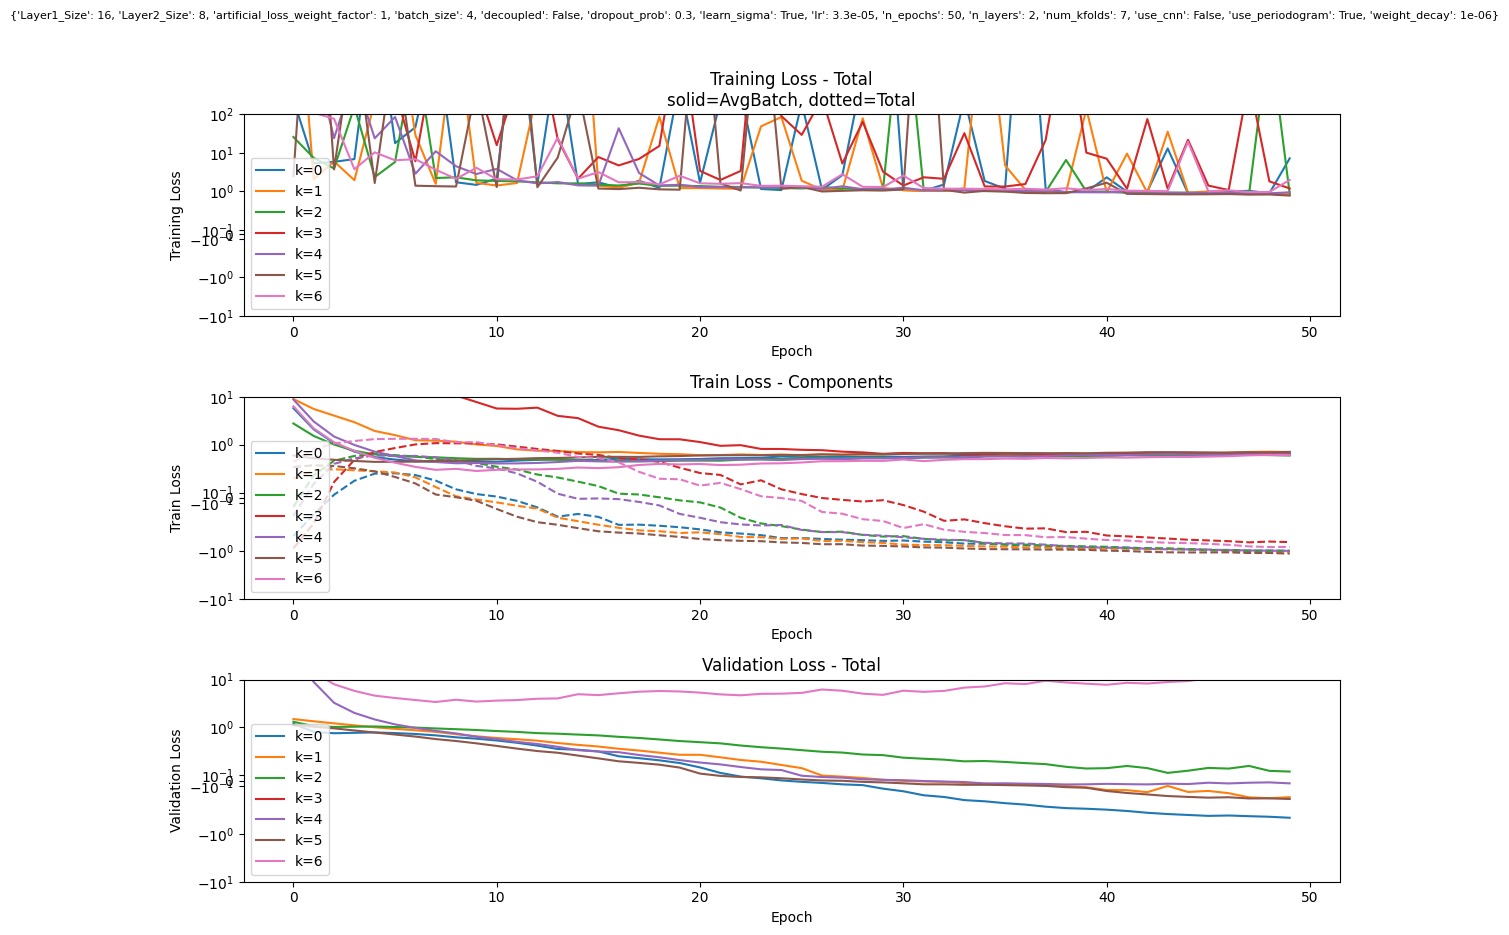

  Run # 1 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0001, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 10335.0020)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2076196.1250)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2523.7039)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1777.1553)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 4243.8306)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 7632.7944)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 3354.1104)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 568.2984)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 270.6886)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 216857.8594)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 294.8153)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 309.3531)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 61774.5430)
[CLIP WARNING] Gradient norm was clipped to 250.

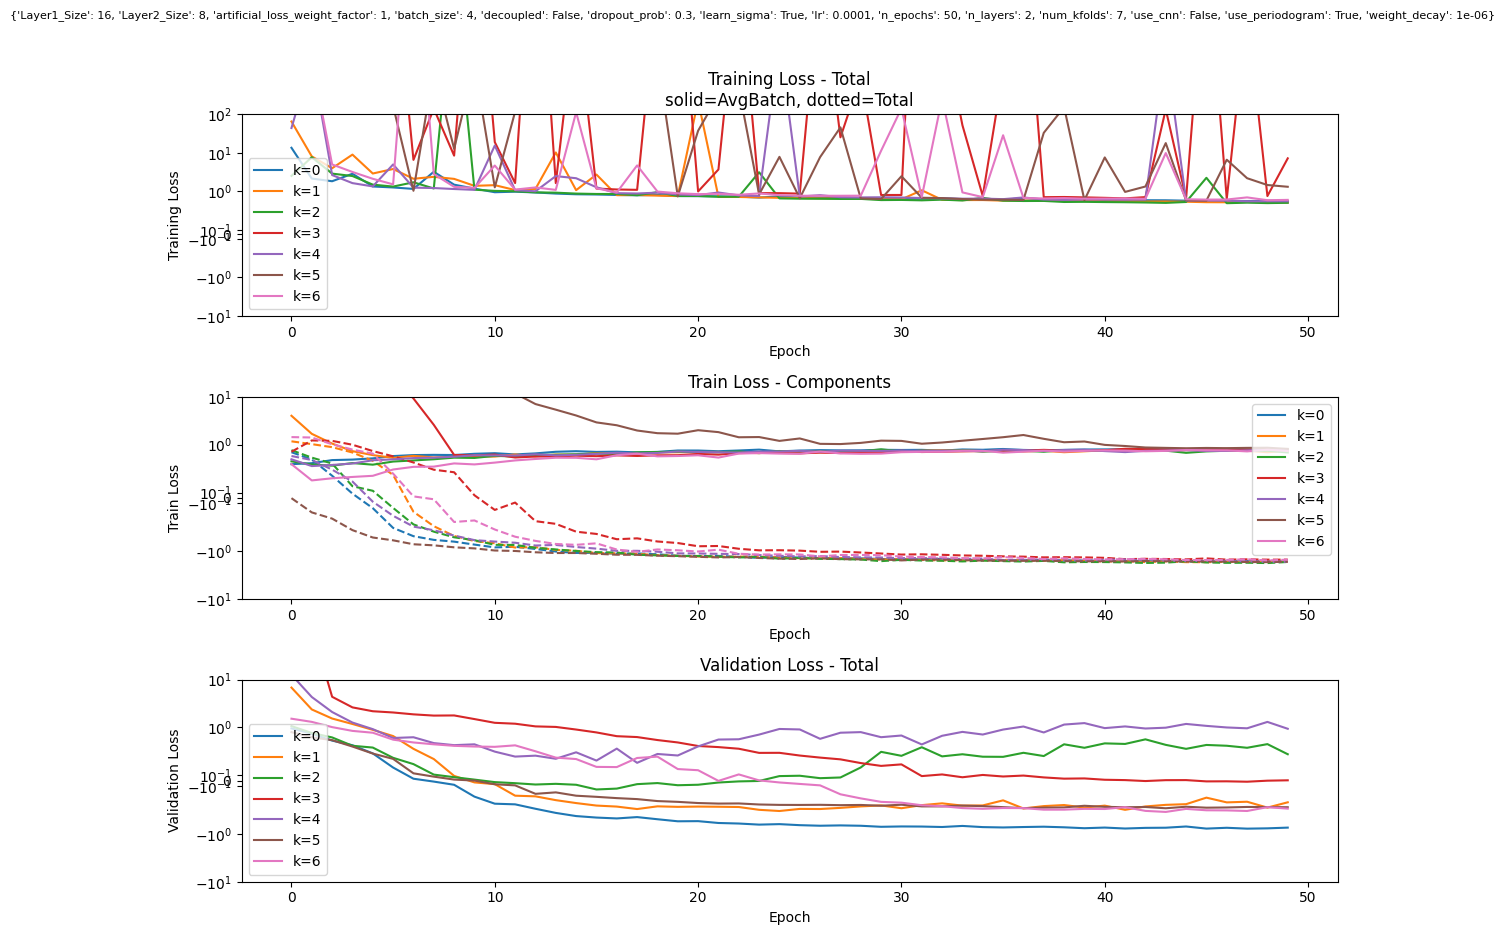

  Run # 2 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0003, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 

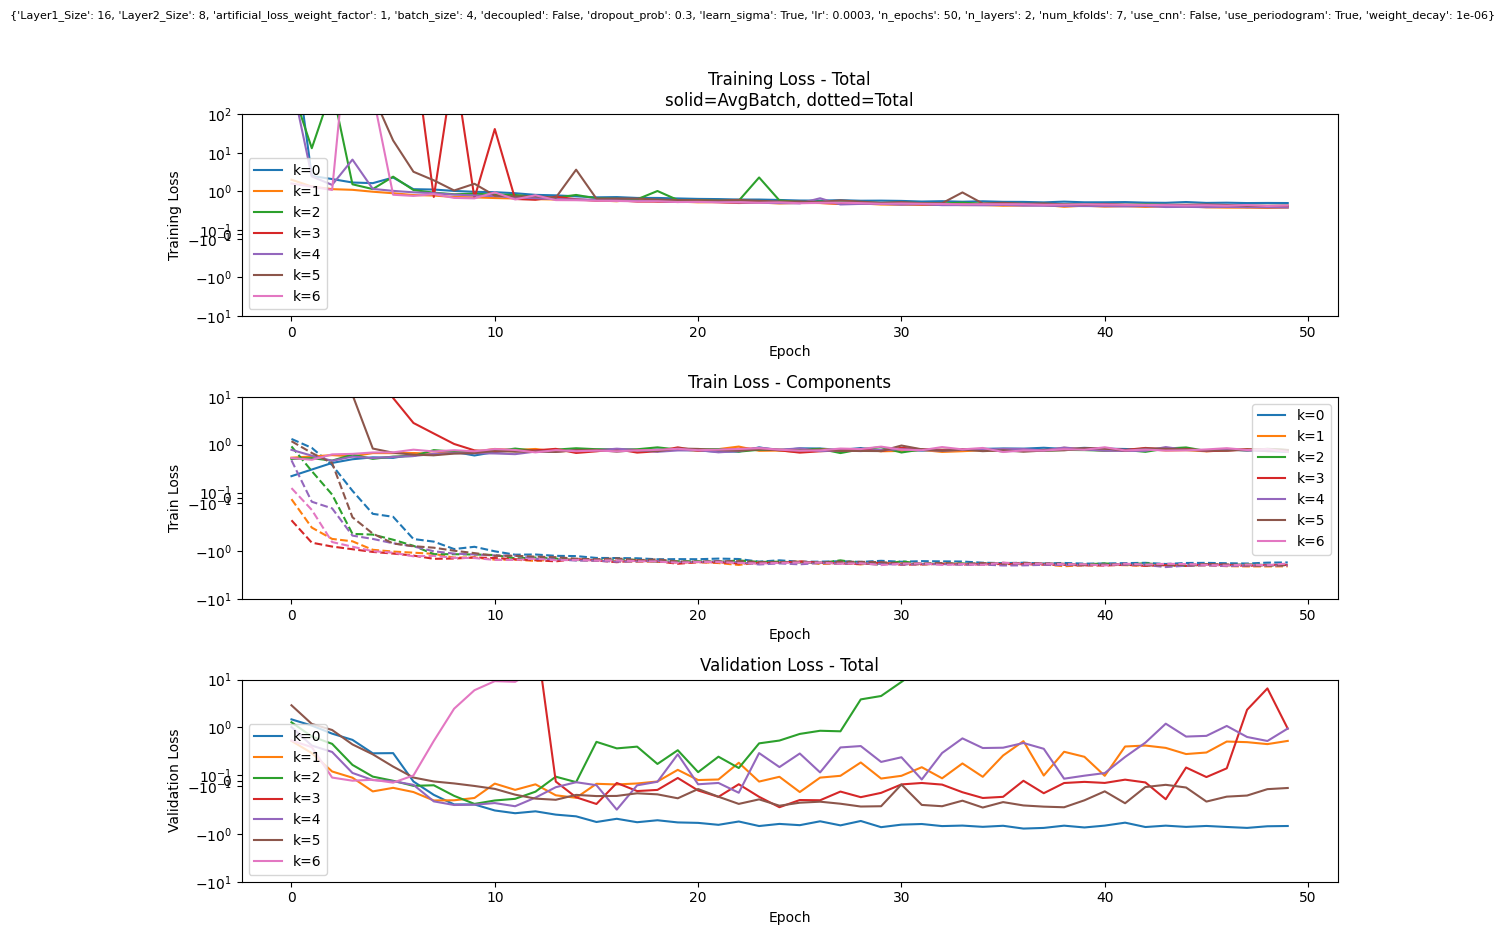

  Run # 3 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0009, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 7856.4443)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 780.9975)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 346.4628)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 4615.0962)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1051.8306)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 906.3752)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 293.7814)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1038685044736.0000)
   Epoch 0, Loss: 77039047586097468311280287744.00, Estimated Time Left: 1.83 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 498.9433)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 189618585600.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2941355.7500)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1145.4893)
Bad gradient detected in su

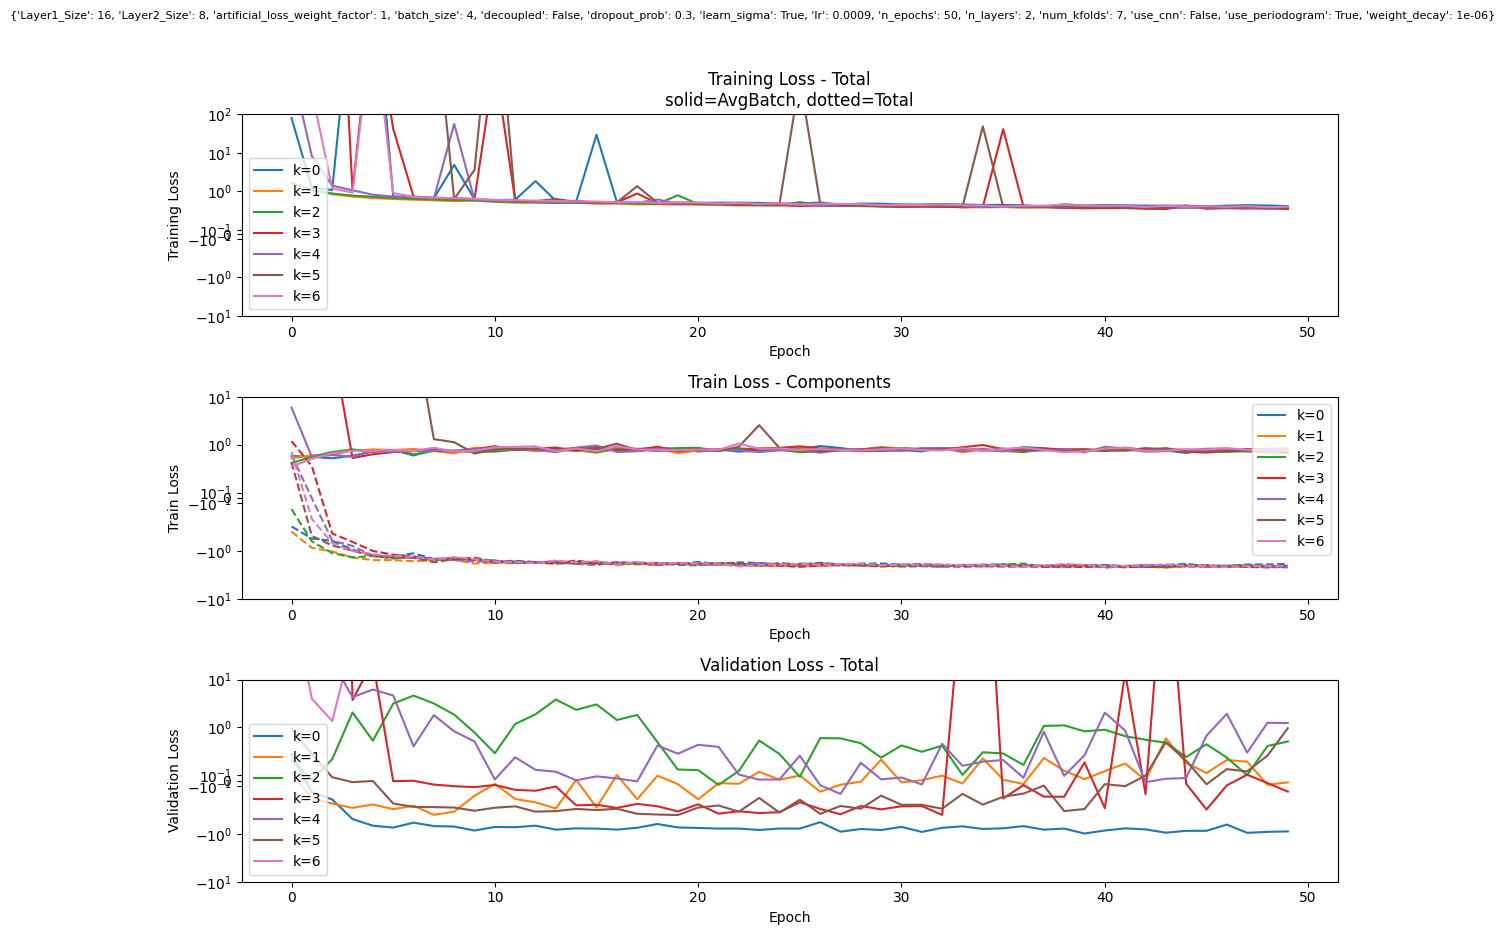

  Run # 4 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0027, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 

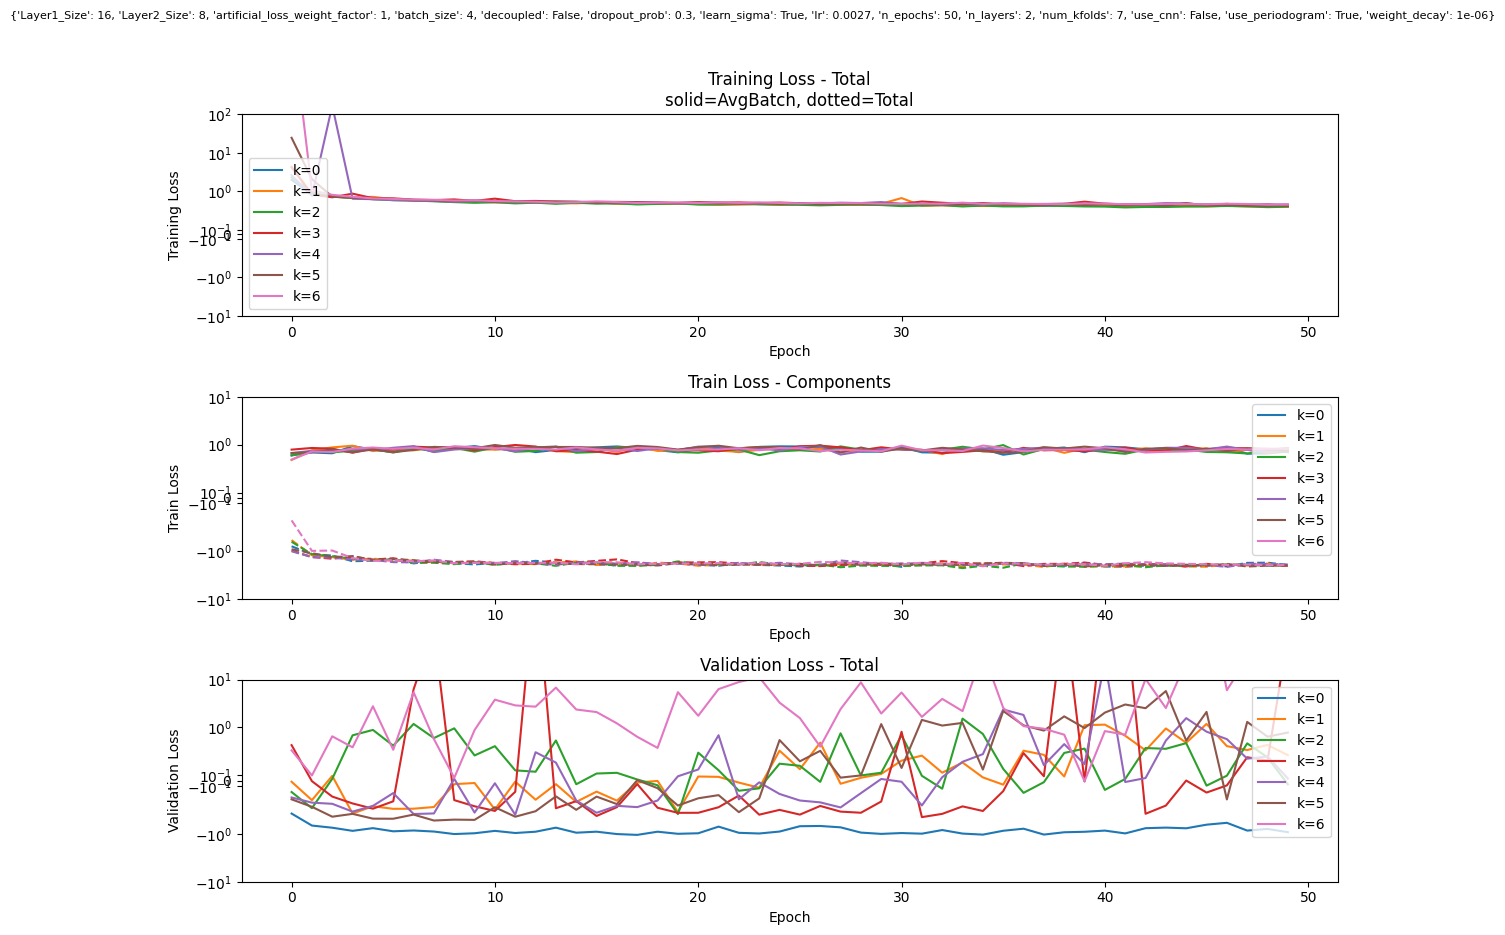

  Run # 5 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 20, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 3.3e-05, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 228184.6094)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 201732.9688)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 305.0277)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2942328576.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 211896.7344)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1969.3676)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1854.5388)
   Epoch 25, Loss: 23.69, Estimated Time Left: 0.54 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 533977.0625)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 292202.4375)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 19888.7773)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 148614864.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 120286184.0000)
[CLIP WARNING] Gradient norm was clipped t

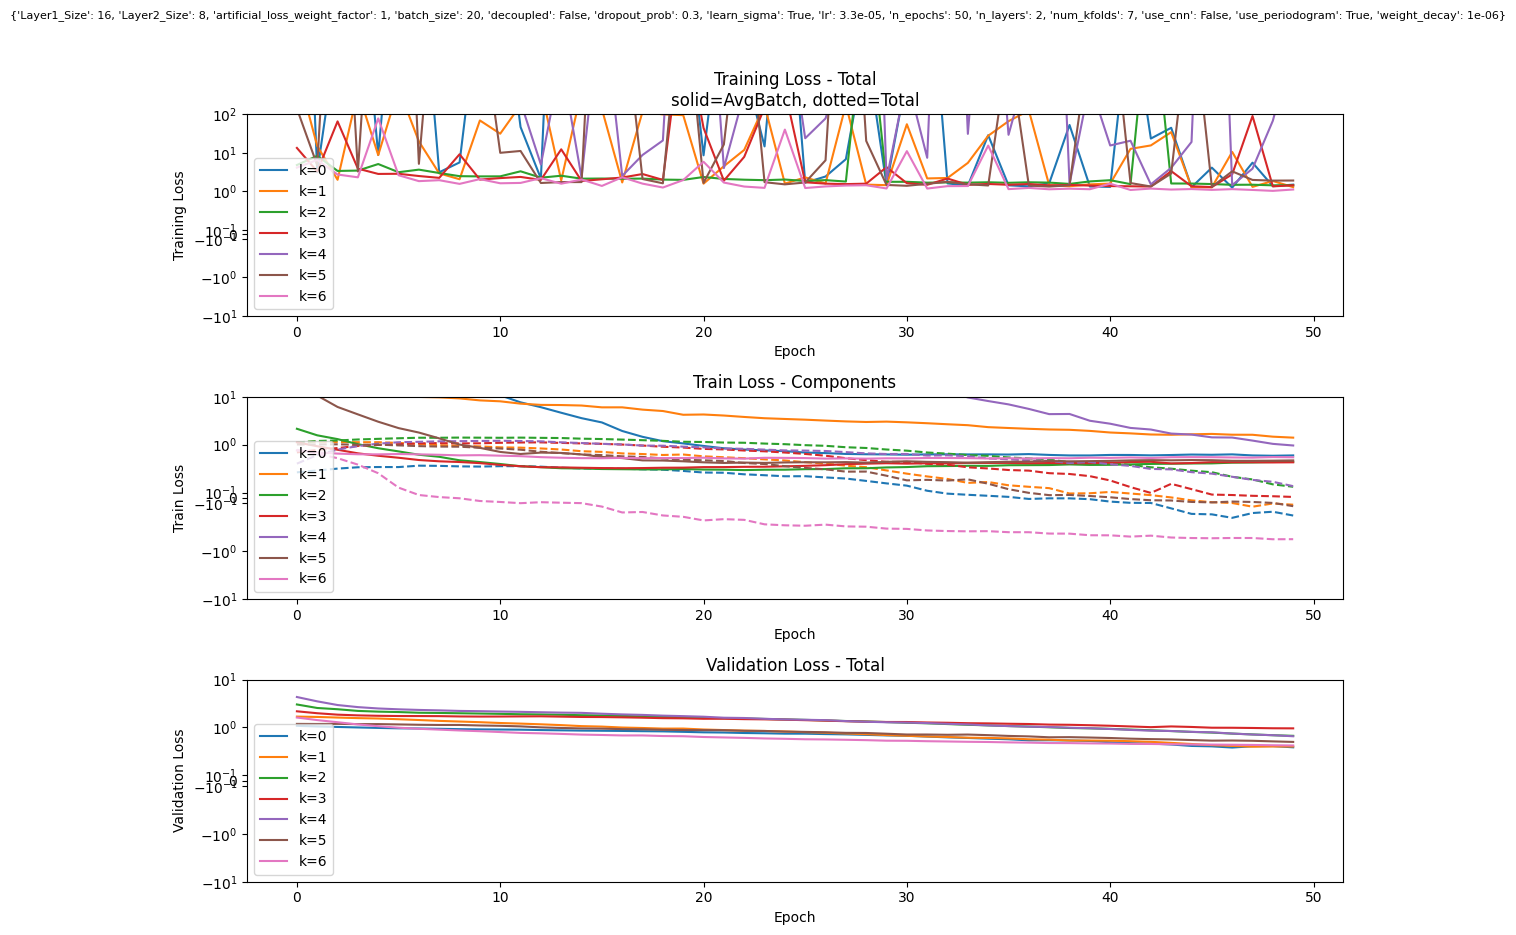

  Run # 6 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 20, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0001, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before:

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 11291711.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 38094.0352)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 4501.5879)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 5599.2954)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 660.9950)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 9966.5928)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 14121.9365)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 7849.3081)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2940.5032)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 5562.0674)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 165128.6406)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1467821.1250)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 24632.0078)
[CLIP WARNING] Gradient norm was clipped

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 254.8403)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1961.9861)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1697.9406)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1031.3983)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 11973.2422)
   Epoch 0, Loss: 521526561250255911851596380635136.00, Estimated Time Left: 0.56 min
NaN or Inf detected in loss!
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 300.9836)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 3138.2246)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1464.1896)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 74947.3281)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 316.5886)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 473.1188)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 656.6455)
[CLIP WARNIN

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:383: RuntimeWarning: invalid value encountered in add
  np.asarray(log["valid_errLoss"]) + np.asarray(log["valid_sigmaLoss"]),


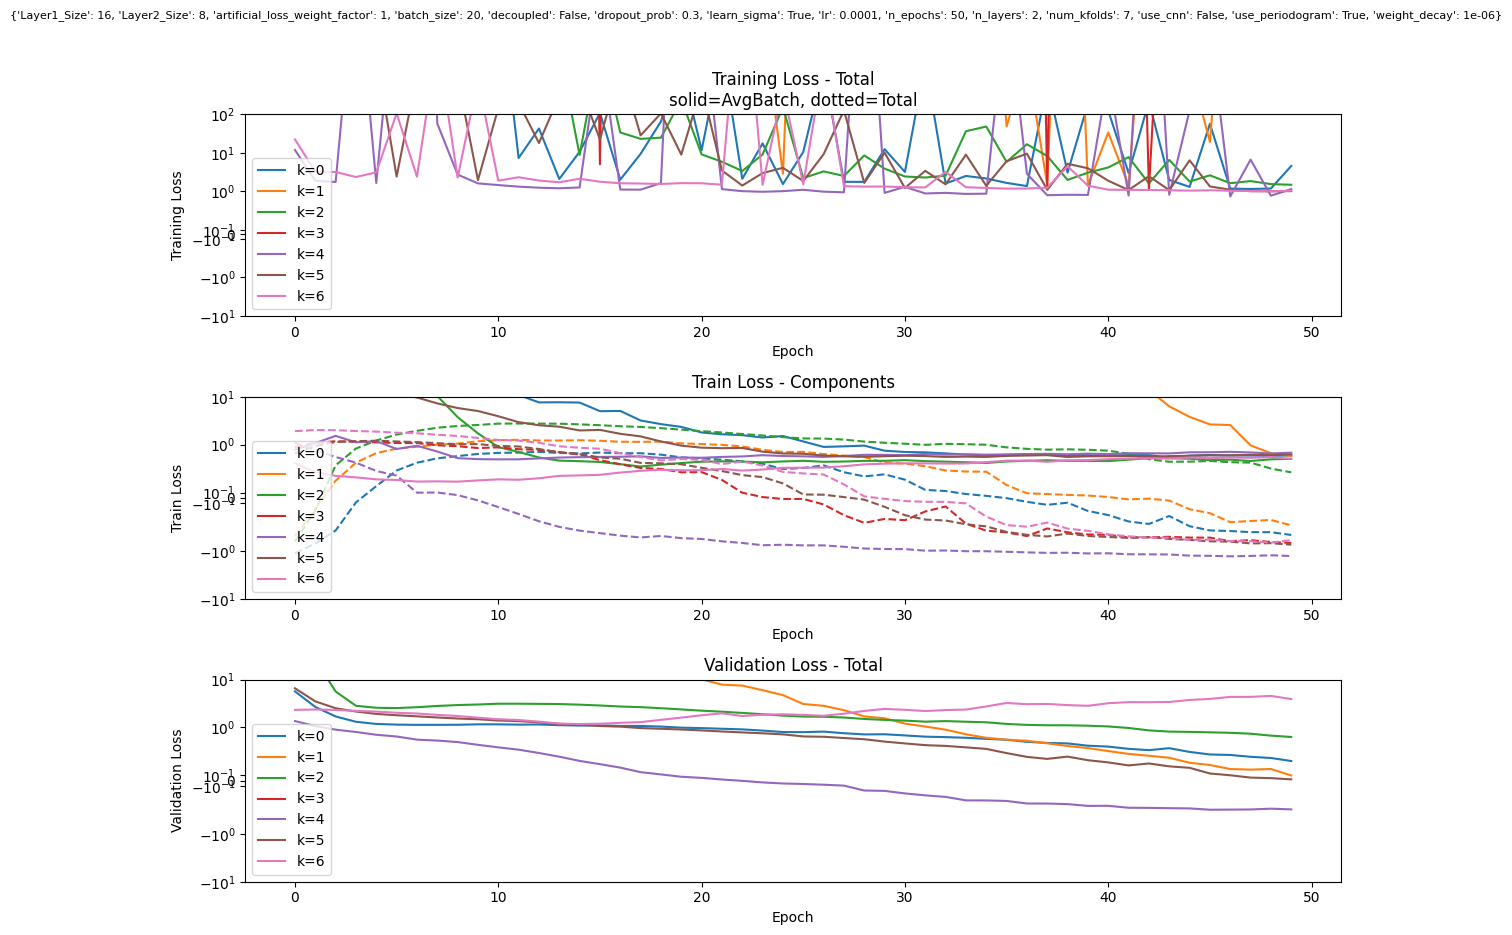

  Run # 7 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 20, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0003, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before:

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 12938.2539)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1422.0450)
Bad gradient detected in summary_branch.0.weight
Bad gradient detected in summary_branch.0.bias
Bad gradient detected in periodogram_branch.0.weight
Bad gradient detected in periodogram_branch.0.bias
Bad gradient detected in fc_log_sigma.weight
Bad gradient detected in fc_log_sigma.bias
Skipping optimizer
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 10347311.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 316583.3125)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 436.4555)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 81529.5078)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 380.0016)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 173808.3594)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 266.4639)
[CLIP WARNING] Gradient norm 

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 26612191232.0000)
   Epoch 0, Loss: 147772896759894208.00, Estimated Time Left: 0.59 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 19365064.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 517.4007)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 97793253376.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 862577.7500)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 16586.5996)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 12024.5449)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 831.8135)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 16531.3242)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 21183660.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 376630509568.0000)
Bad gradient detected in summary_branch.0.weight
Bad gradient detected in summary_branch.0.bi

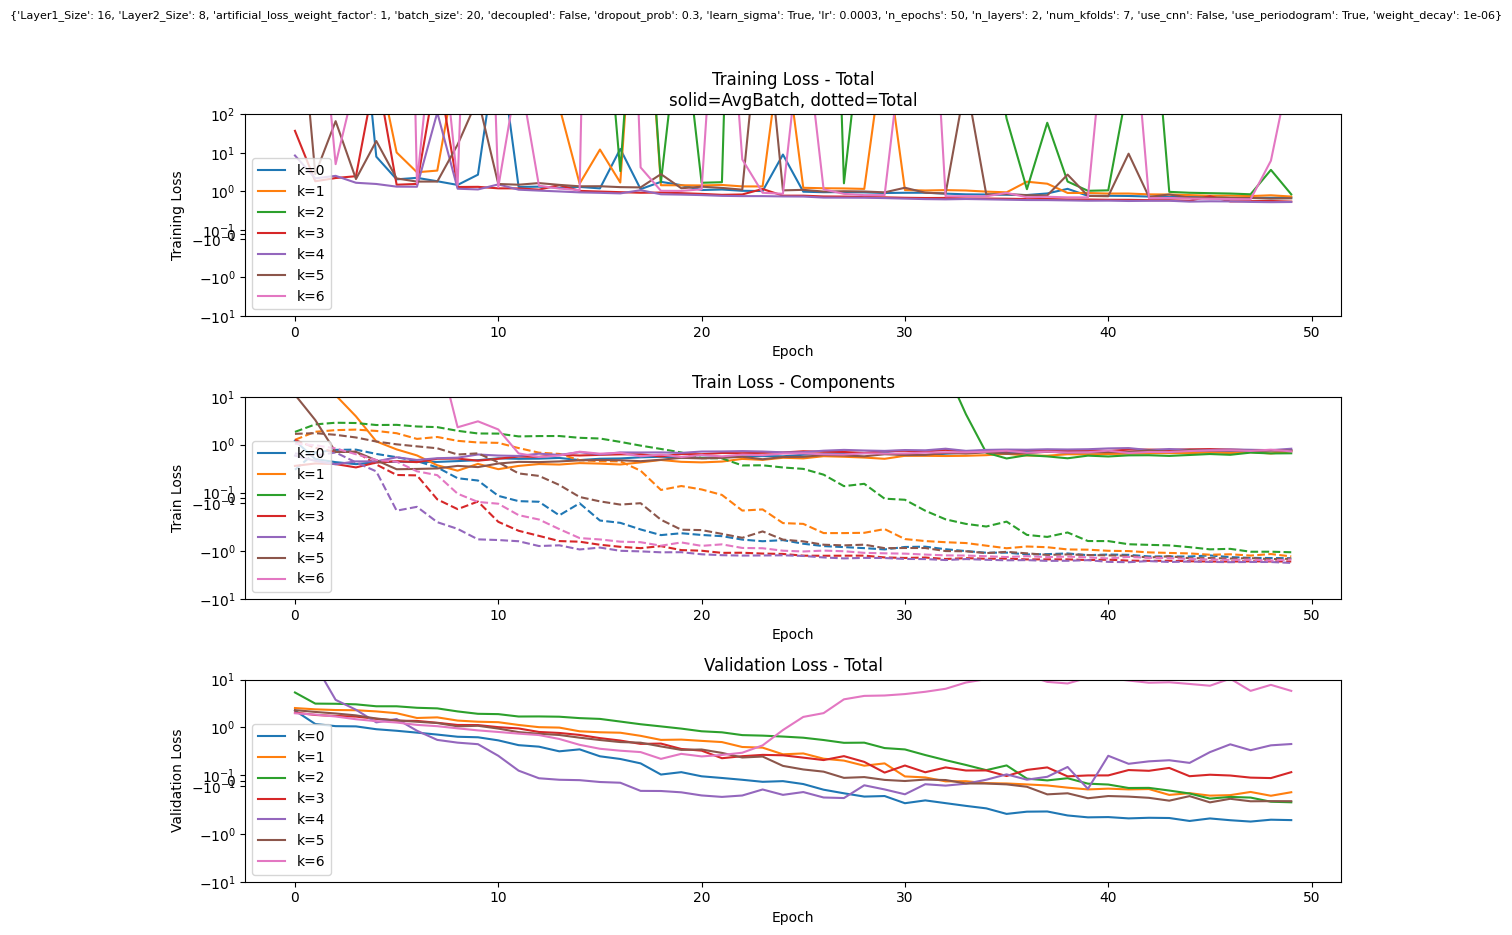

  Run # 8 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 20, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0009, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before:

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 8218781.5000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 784.8819)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 36704.5078)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1188.2629)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 296.0016)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 15914.1104)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 13924680704.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1023.3945)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 3292755.7500)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1015581.3750)
   Epoch 0, Loss: 74836407136177568.00, Estimated Time Left: 0.64 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 536.5424)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 212357.8906)
[CLIP WARNING] Gradient norm was clip

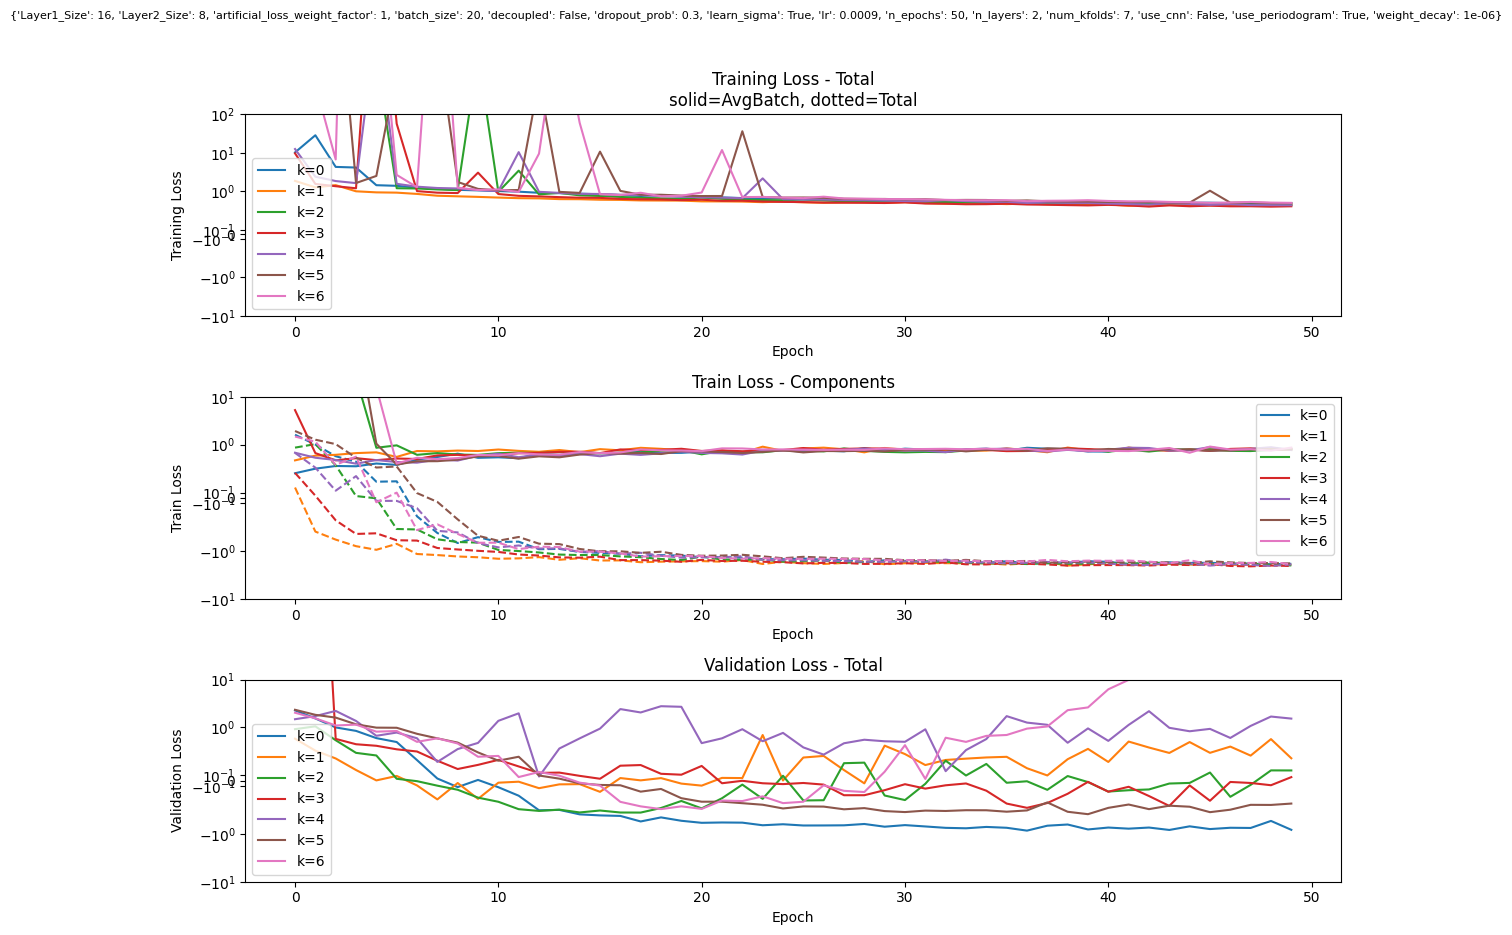

  Run # 9 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 20, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0027, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before:

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 354.1898)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 57938632.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 4564.2446)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 564039130284032.0000)
Bad gradient detected in summary_branch.0.weight
Bad gradient detected in summary_branch.0.bias
Bad gradient detected in periodogram_branch.0.weight
Bad gradient detected in periodogram_branch.0.bias
Bad gradient detected in fc_log_sigma.weight
Bad gradient detected in fc_log_sigma.bias
Skipping optimizer
   Epoch 5, Loss: 2312028051465099264.00, Estimated Time Left: 0.63 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 5950.5513)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 38196972.0000)
   Epoch 10, Loss: 957.48, Estimated Time Left: 0.54 min
NaN or Inf detected in loss!
   Epoch 15, Loss: 0.60, Estimated Time Left: 0.50 min
[CLIP WARNING] Gradient 

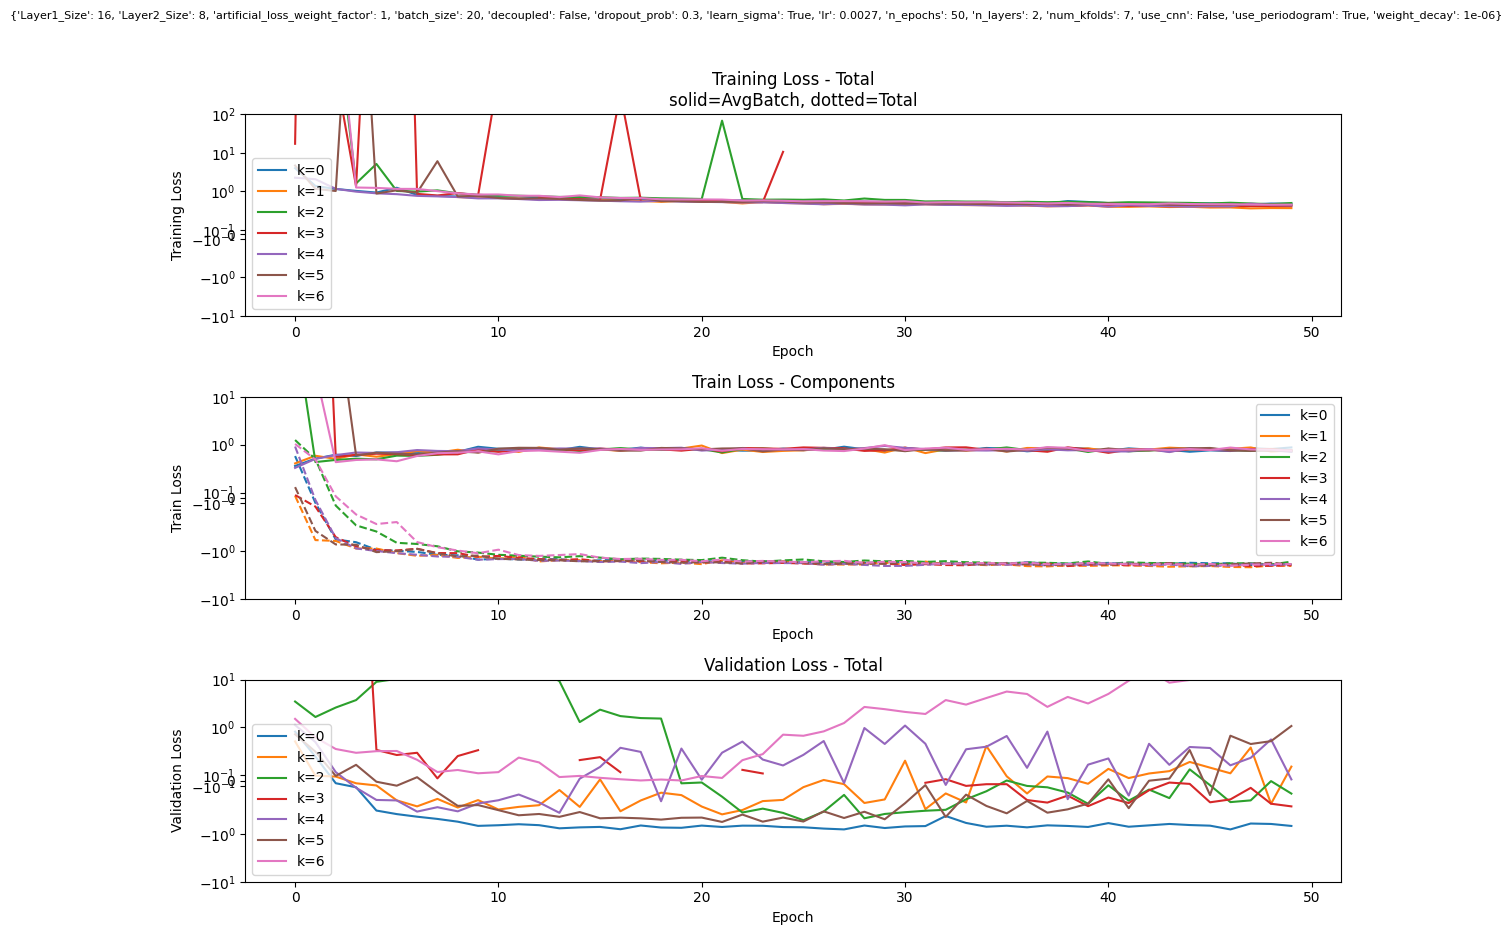

  Run # 10 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 100, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 3.3e-05, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
   Epoch 0, Loss: 2.15, Estimated Time Left: 0.37 min
[CLI

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


   Epoch 0, Loss: 385009138311611776.00, Estimated Time Left: 0.13 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2588.1968)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2058.4224)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 547.9387)
Bad gradient detected in summary_branch.0.weight
Bad gradient detected in summary_branch.0.bias
Bad gradient detected in periodogram_branch.0.weight
Bad gradient detected in periodogram_branch.0.bias
Bad gradient detected in fc_log_sigma.weight
Bad gradient detected in fc_log_sigma.bias
Skipping optimizer
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 8709.5762)
Bad gradient detected in summary_branch.0.weight
Bad gradient detected in summary_branch.0.bias
Bad gradient detected in periodogram_branch.0.weight
Bad gradient detected in periodogram_branch.0.bias
Bad gradient detected in fc_log_sigma.weight
Bad gradient detected in fc_log_sigma.bias
Skipping optimizer
[CLIP WARNING] Gradient 

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 113083.1172)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1227.0614)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 21766.1895)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 441973.4062)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 9595.5156)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 358765.6875)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 13008.4092)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 92263.5312)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 68619.6875)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 589.8604)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 307.7796)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 463481.4688)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2092.8225)
[CLIP WARNING] Gradient norm was clipped 

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1646.6555)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2143.2664)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 91709.0391)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 323.2707)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 874.1156)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1487.5648)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1248.2627)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 6207.7109)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 460.2120)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 3849.9937)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1431.5612)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2502338.2500)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1047.1910)
[CLIP WARNING] Gradient norm was clipped to 250.00

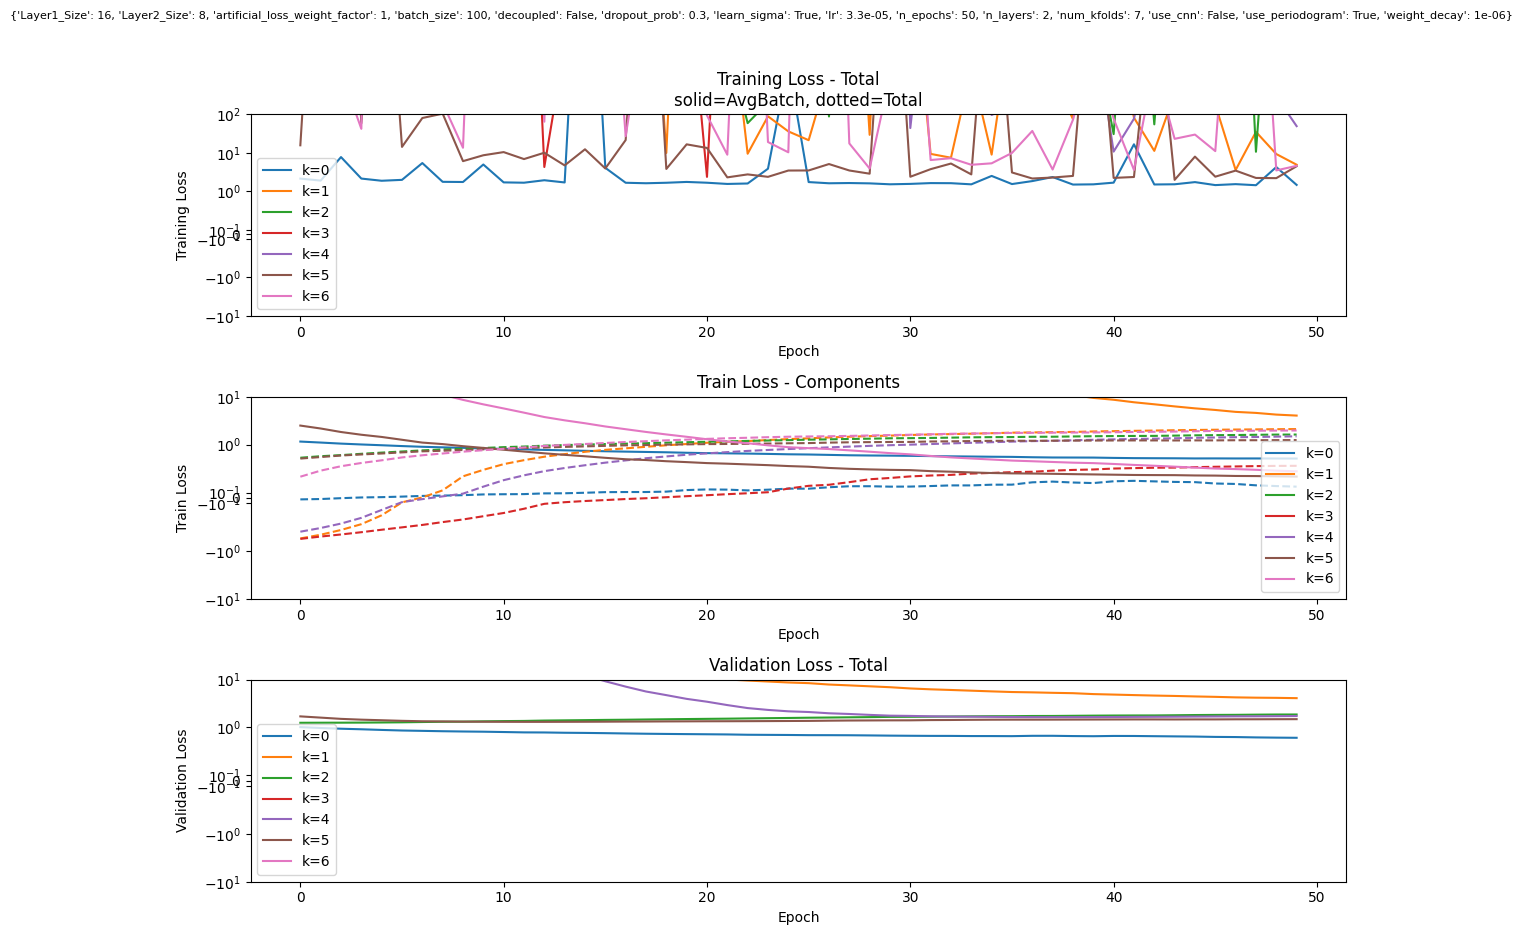

  Run # 11 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 100, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0001, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (befor

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 459.0386)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 829.4434)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 52116316.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 704754.6875)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 79778400.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1053.2766)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 55746.2969)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 50943.2617)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 14802.9375)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 18457.9688)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 75873.7891)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 16869.2773)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 735871.0000)
[CLIP WARNING] Gradient norm was cl

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 27440.8672)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 4106156.2500)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 128741.0312)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 5128.7319)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 815.6273)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 6398.4287)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 605.7544)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 937.5143)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 673.7757)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 7773.6289)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1493.6069)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1537947648.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 672.5778)
[CLIP WARNING] Gradient norm was clipped to 

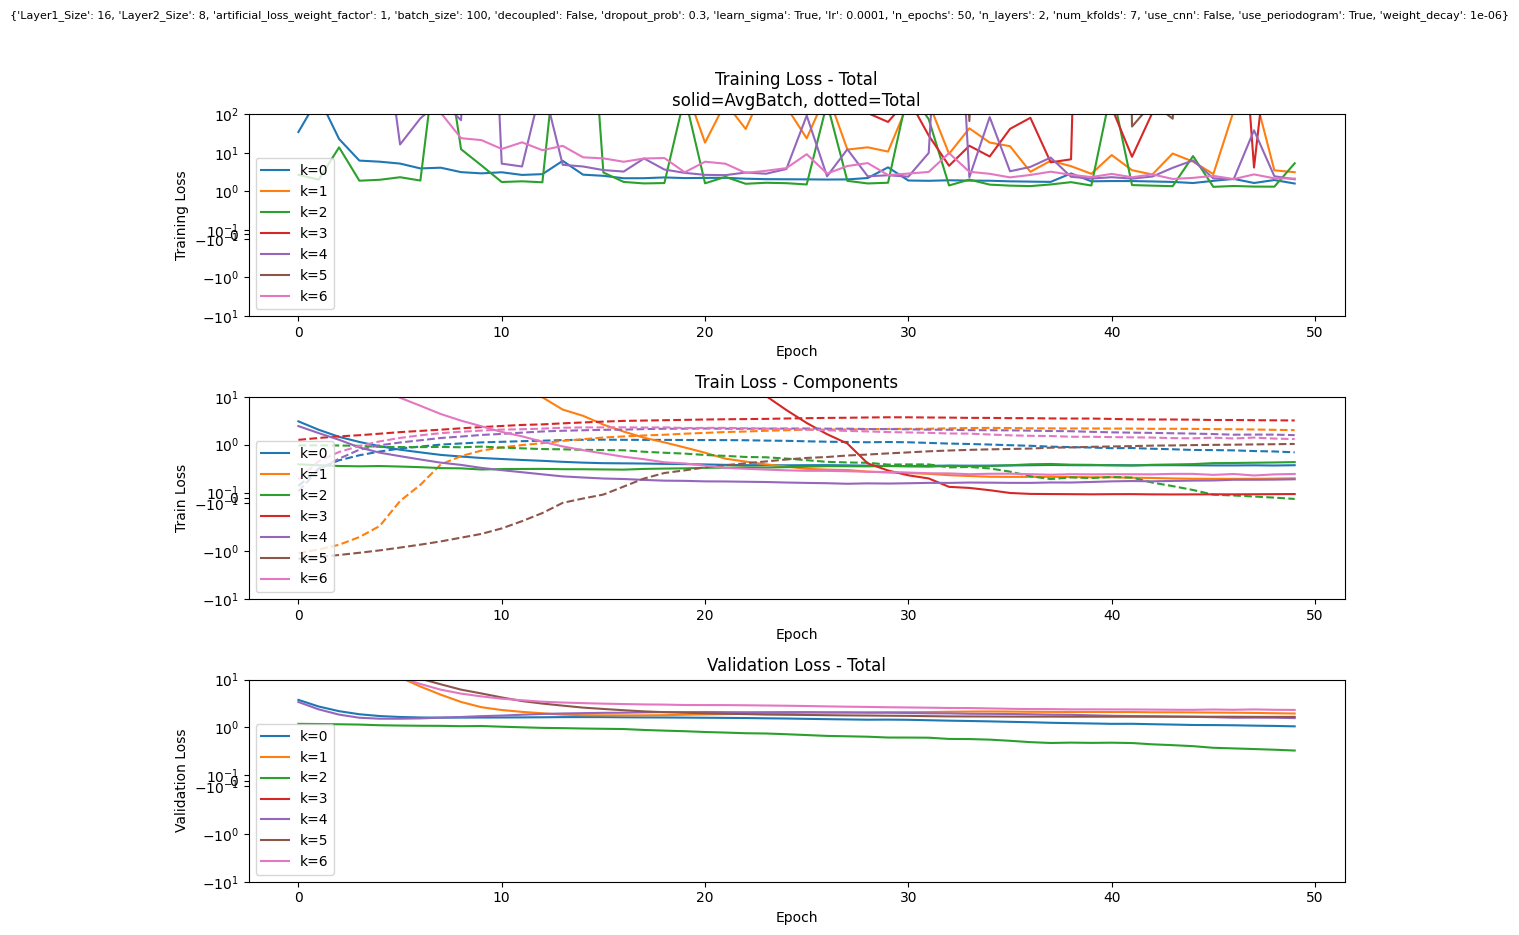

  Run # 12 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 100, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0003, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (befor

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 795.0420)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 498.8430)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 3646.0378)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 30083.0547)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 50194976.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 413.9309)
   Epoch 0, Loss: 7311312200432390055657472.00, Estimated Time Left: 0.14 min
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 18188.4922)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1080.9702)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 585302976.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 1340.8853)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 429.0012)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 548.4832)
[CLIP WARNING] Gradient norm was clipped

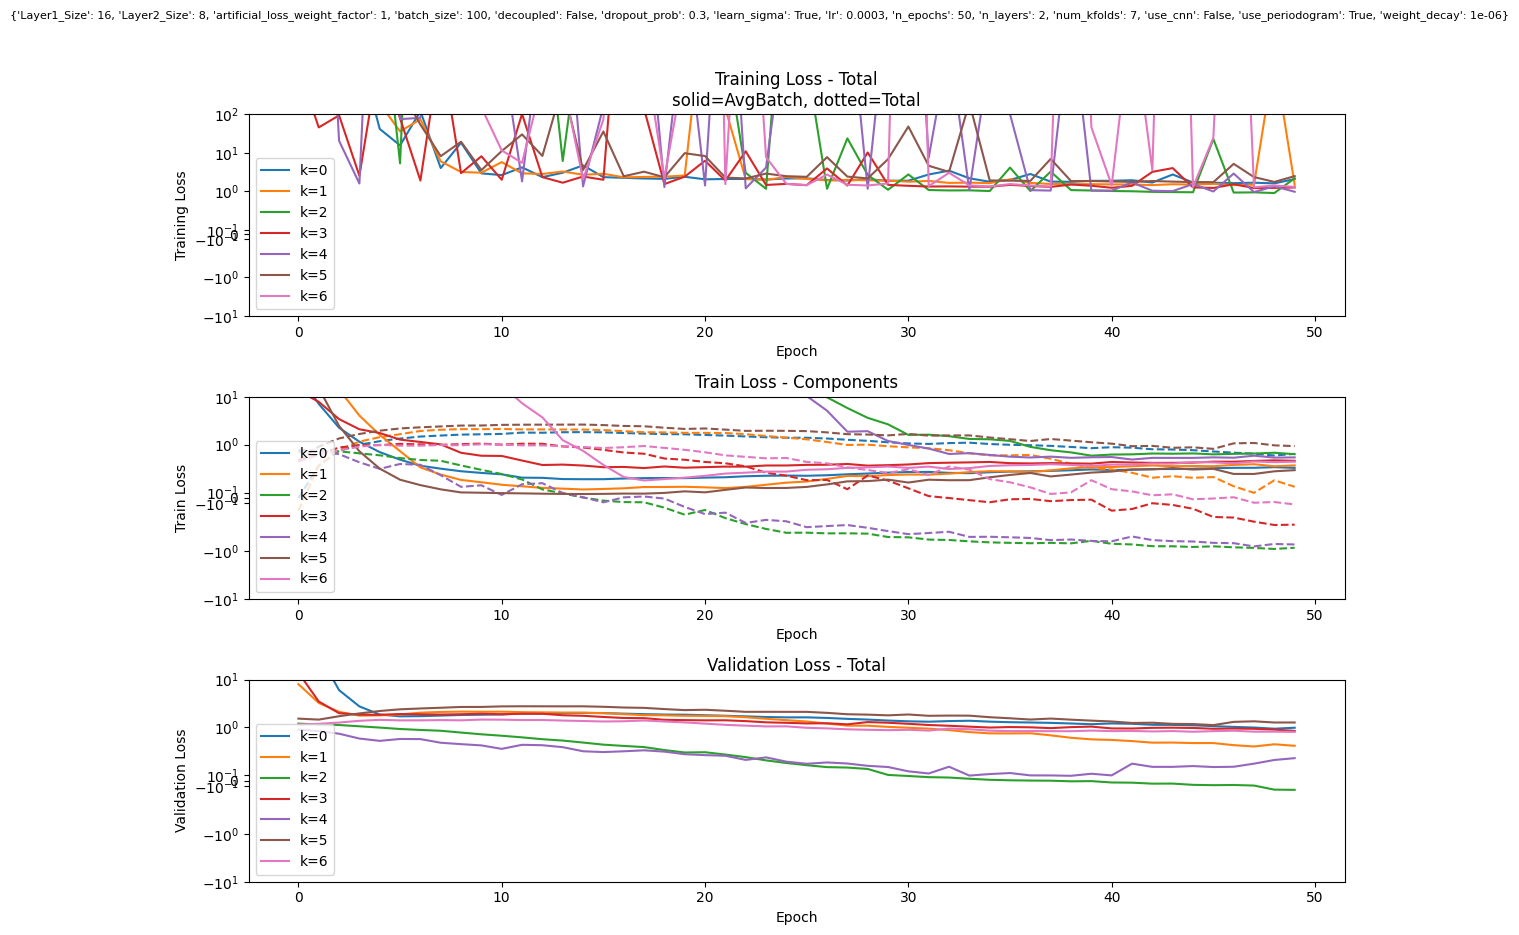

  Run # 13 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 100, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0009, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (befor

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 942.2364)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 6214.4658)
NaN or Inf detected in loss!
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2755047.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2142.8855)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 649.4547)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 28081.4707)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 951.8864)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 10621.3633)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2005049.1250)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 13980.0576)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 2231.1558)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 6843852288.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 503411.6875)
[CLIP WA

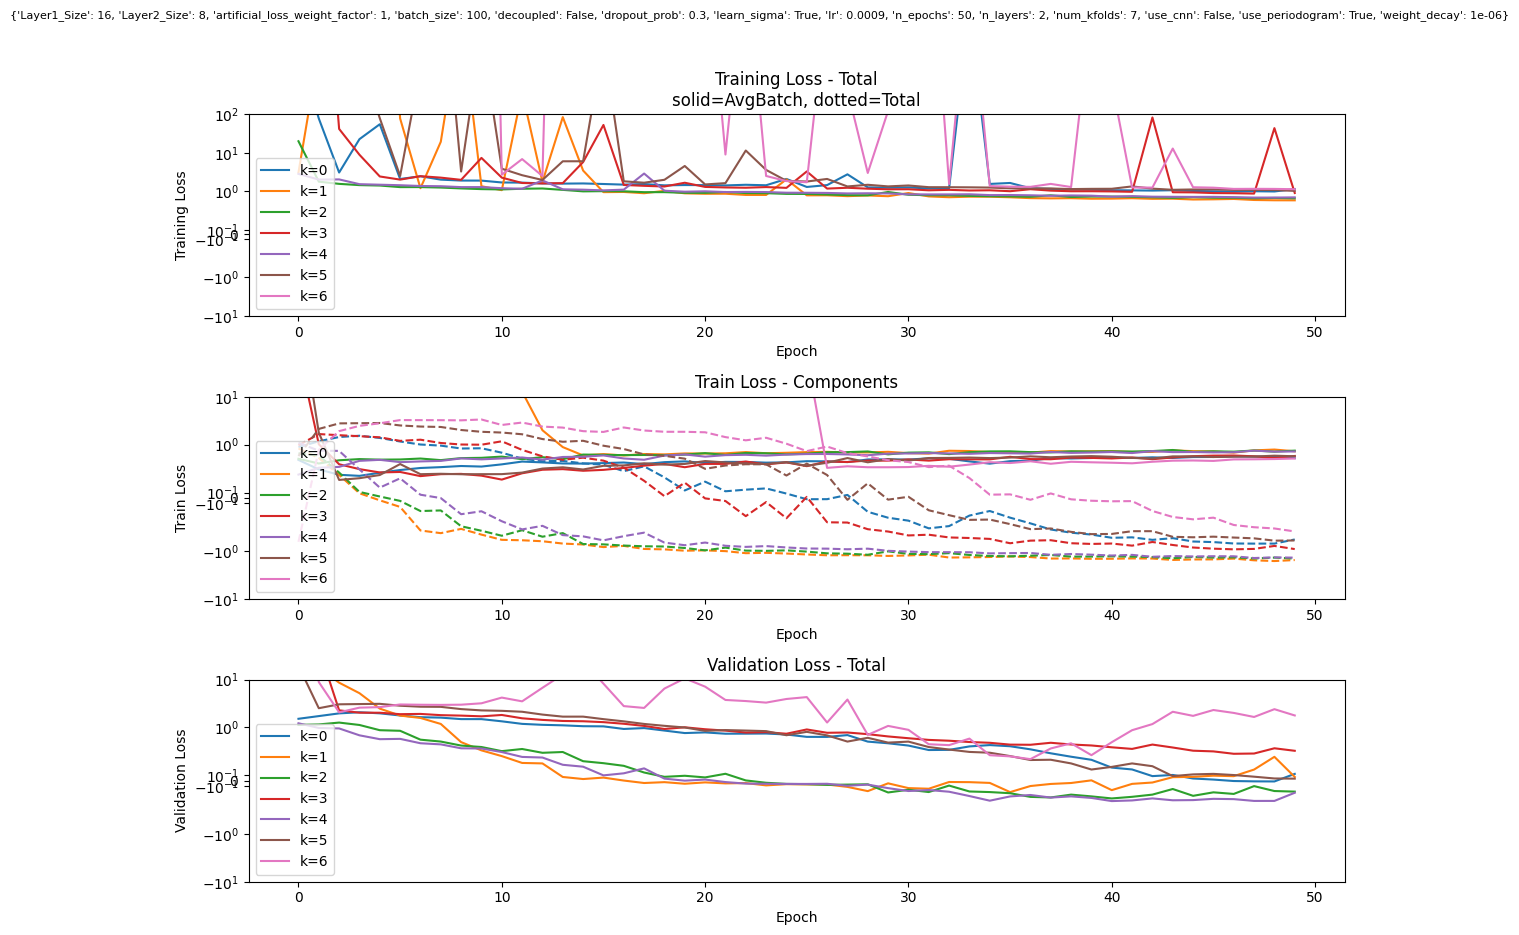

  Run # 14 , Params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 100, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0027, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
ASSERT 3972 3972

--- Fold 1 ---
Validation clusters in fold #0: [b'ASCC 8' b'BERKELEY 43' b'Bruck 71' b'Bruck 72' b'Bruck 74' b'Bruck 86'
 b'Cl Kron 42' b'Cl Lindsay 33' b'ESO 130-13' b'FSR 0192' b'FSR 0253'
 b'FSR 0336' b'FSR 1513' b'FSR 1668' b'H88 336' b'IC 4996' b'KMHK1292'
 b'NGC 6216' b'NGC 6885' b'NGC152' b'NGC1652' b'NGC1695' b'NGC1698'
 b'NGC1735' b'NGC1749' b'NGC1772' b'NGC1951' b'NGC2000' b'NGC2041'
 b'NGC2095' b'NGC2159' b'NGC2172' b'NGC220' b'NGC290' b'NGC419'
 b'OGLE-CL SMC 53' b'PISMIS 6' b'RUPRECHT 83' b'[BS95] 35' b'[H86] 191'
 b'[H86] 87' b'[PIR2016] VMC17' b'[PIR2016] VMC19' b'[PIR2016] VMC27'
 b'[SL63] 105']
[CLIP WARNING] Gradient norm was clipped to 250.0000 (befor

/Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/Training_HelperFcns.py:209: UserWarning: Skipping optimizer step due to NaN or Inf in gradients.
  warnings.warn("Skipping optimizer step due to NaN or Inf in gradients.")


   Epoch 0, Loss: nan, Estimated Time Left: 0.31 min
Bad gradient detected in summary_branch.0.weight
Bad gradient detected in summary_branch.0.bias
Bad gradient detected in periodogram_branch.0.weight
Bad gradient detected in periodogram_branch.0.bias
Bad gradient detected in fc_log_sigma.weight
Bad gradient detected in fc_log_sigma.bias
Skipping optimizer
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 12709060558192640.0000)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 255.2656)
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: 4292.8677)
NaN or Inf detected in loss!
[CLIP WARNING] Gradient norm was clipped to 250.0000 (before: inf)
Bad gradient detected in summary_branch.0.weight
Bad gradient detected in summary_branch.0.bias
Bad gradient detected in periodogram_branch.0.weight
Bad gradient detected in periodogram_branch.0.bias
Bad gradient detected in fc_log_sigma.weight
Bad gradient detected in fc_log_sigma.bias
Skipping optimizer
[CLIP 

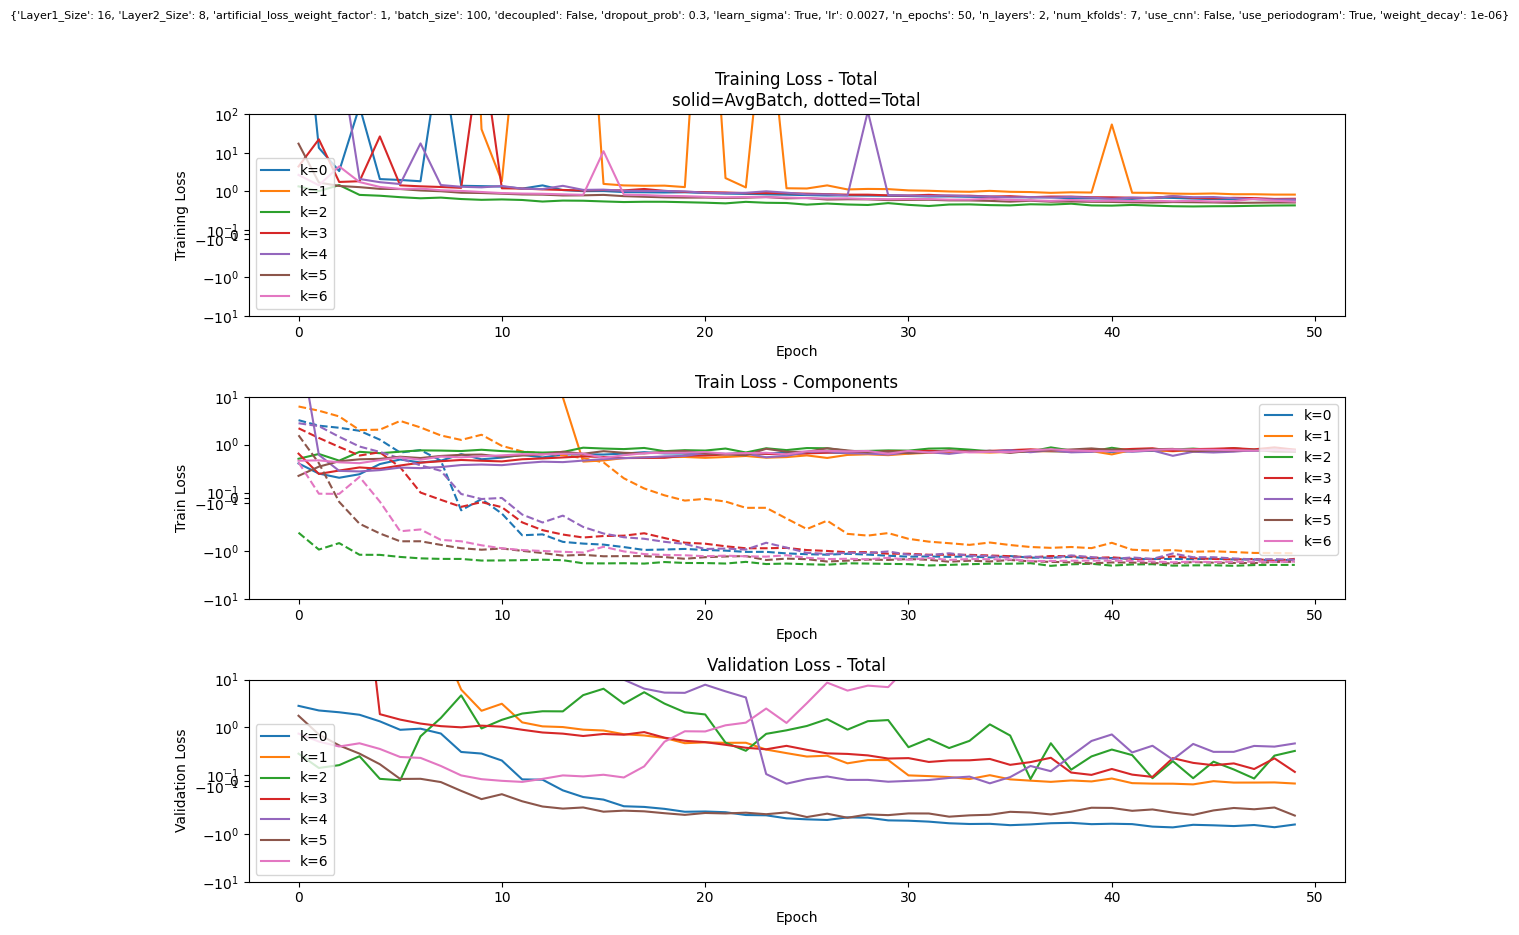

In [25]:

import time

# Define which datasets you wish to use.
# Here there is just one, but the code could handle more if you specifiy different ones here.

summary_stat_dims = [X_train.shape[1]]
periodogram_dims = [period_train.shape[1]]

model_train_data_statistics   = [X_train]
model_train_data_periodogram  = [period_train]
model_train_data_Y            = [y_train]
model_train_data_clusternames = [train_cluster_names]

model_test_data_statistics    = [X_test]
model_test_data_periodogram   = [period_test]
model_test_data_Y             = [y_test]

model_names = ['Test_Model']

#### Define the model Hyperparameters. A grid of all cominations will be run.
params = {
    'use_periodogram': [True], # If True, Runs the model with the periodigram data
    'use_cnn': [False],        # If True, Runs the periodigram data using 
    'decoupled': [False],
    'learn_sigma': [True],
        
    'n_layers': [2],
    'Layer1_Size': [16],
    'Layer2_Size': [8],

    'dropout_prob': [0.3],
    'lr':   [0.33e-4, 1e-4, 3e-4, 9e-4, 27e-4],   # spaced by 3
    'batch_size': [4, 20, 100],         # np.logspace(3, 4, 2), #

    'n_epochs': [50],
    'artificial_loss_weight_factor': [1],
    'weight_decay': [1e-6],
    'num_kfolds': [7]
}

empty_train_log = {
        "epoch" : [], 
        "mean_batch_loss" : [], 
        "train_errLoss" : [], 
        "train_sigmaLoss" : [], 
        "train_Loss" : [], 
        "train_MAE"  : [], 
        "train_RMSE" : [], 
        "train_median_sigma" : [], 
        "train_mean_sigma" : [], 
        "train_Coverage68" : [], 
        "train_Coverage95" : [], 
        "train_CRPS" : [], 
        "valid_errLoss" : [], 
        "valid_sigmaLoss" : [], 
        "valid_Loss" : [], 
        "valid_MAE"  : [], 
        "valid_RMSE" : [], 
        "valid_median_sigma" : [], 
        "valid_mean_sigma" : [], 
        "valid_Coverage68" : [], 
        "valid_Coverage95" : [], 
        "valid_CRPS" : [], 
}               

all_runs_log = {
    model_name: {
        run_id: {
            **{
                "params": config_dict,
            },
            **{
                k_id: {
                    "model": None,
                    "log": copy.deepcopy(empty_train_log)
                } for k_id in range(config_dict['num_kfolds'])
            }
        } for run_id, config_dict in enumerate(ParameterGrid(params))
        # SHOULD ADD THE MODEL DATA HERE, wont be memory efficient but much cleaner code for plotting and our data is small.
    } for model_name in model_names
    
}



for i, model_name in enumerate(model_names):    
    stats_dim = summary_stat_dims[i] # X_train.shape[1]
    period_dim = periodogram_dims[i] # period_train.shape[1]
    
    X_stats  = model_train_data_statistics[i]
    X_period = model_train_data_periodogram[i]
    X_cluster_names = model_train_data_clusternames[i]
    Y        = model_train_data_Y[i]
    
    test_X_stats  = model_test_data_statistics[i]
    test_X_period = model_test_data_periodogram[i]
    test_Y        = model_test_data_Y[i]


    if torch.isnan(X_stats).any():
        print("Warning: NaNs detected in X_train")
    
    if torch.isnan(X_test).any():
        print("Warning: NaNs detected in X_test")
    
    run_id = 0
    for Params in ParameterGrid(params):
        
        print('  Run #', run_id, ', Params:', Params)
        model_class = DualInputNN

        all_runs_log[model_name][run_id] = kfold_cross_validation(X_stats, X_period, X_cluster_names, Y,
                                                                  model_class, Params, 
                                                                  all_runs_log[model_name][run_id], 
                                                                  seed=42)
        
        ## Probably should add a plotting function call here to show how the different folds compare against eachother. ##
        plot_run_log(all_runs_log[model_name][run_id])
        
        run_id += 1
    
    # results_array[i, :] = test_model(model, 
    #                              X_test_tensor, y_test_tensor, 
    #                              X_test_BDATA_tensor, y_test_BDATA_tensor)

    


In [29]:
print('hi')

hi


In [27]:
print('hi2')

hi2


### Export the Training log

Not to be used for long-term saving as the dataset is also relevent, but useful for experimenting and not having to retrain models and such.

In [28]:
import pickle

save_path = temp_files_path+'ModelGridLogs/'
#file_name = 'test_014_fixedGroups_ReduceVariance.pkl'
file_name = 'test_015_fixedGroupsANDleakage_LrBsGrid.pkl'

with open(save_path+file_name, 'wb') as f:
    pickle.dump(all_runs_log, f)


# Monitor Remote Training

**Only use these cells if you ran training remotely (`RUN_REMOTE = True`)**

In [ ]:
# Check if remote training is still running
check_remote_status()

In [ ]:
# View recent training output from log file (more reliable than tmux)
tail_remote_log(lines=100)

In [ ]:
# Sync results back from remote (run this when training is complete)
sync_results_back()

In [ ]:
# Load remote training results
# This will load the most recent training_results_*.pkl file
all_runs_log = load_remote_results()

# Or load a specific file:
# all_runs_log = load_remote_results('training_results_20231215_143022.pkl')

In [ ]:
# Show instructions for manually SSH'ing to remote and attaching to tmux session
attach_remote_instructions()

# Plot the Model Performance

In [14]:
import pickle

load_from_save = True
if load_from_save:
    save_path = temp_files_path+'ModelGridLogs/'
    file_name = 'test_015_fixedGroupsANDleakage_test.pkl'
    
    with open(save_path+file_name, 'rb') as f:
        all_runs_log = pickle.load(f)


In [15]:
# Enable autoreload - automatically reloads modules when they change
%load_ext autoreload
%autoreload 2 

# Load in yt datasets
import sys
sys.path.append(project_dir_path)

from Kfold_PlottingFcns import plot_trainval_loss_evolution, plot_all_metric_evolution
from SingleFold_PlottingFcns import print_and_plot_summary_stats, Plot2Dstatistics_wrapper

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Test_Model


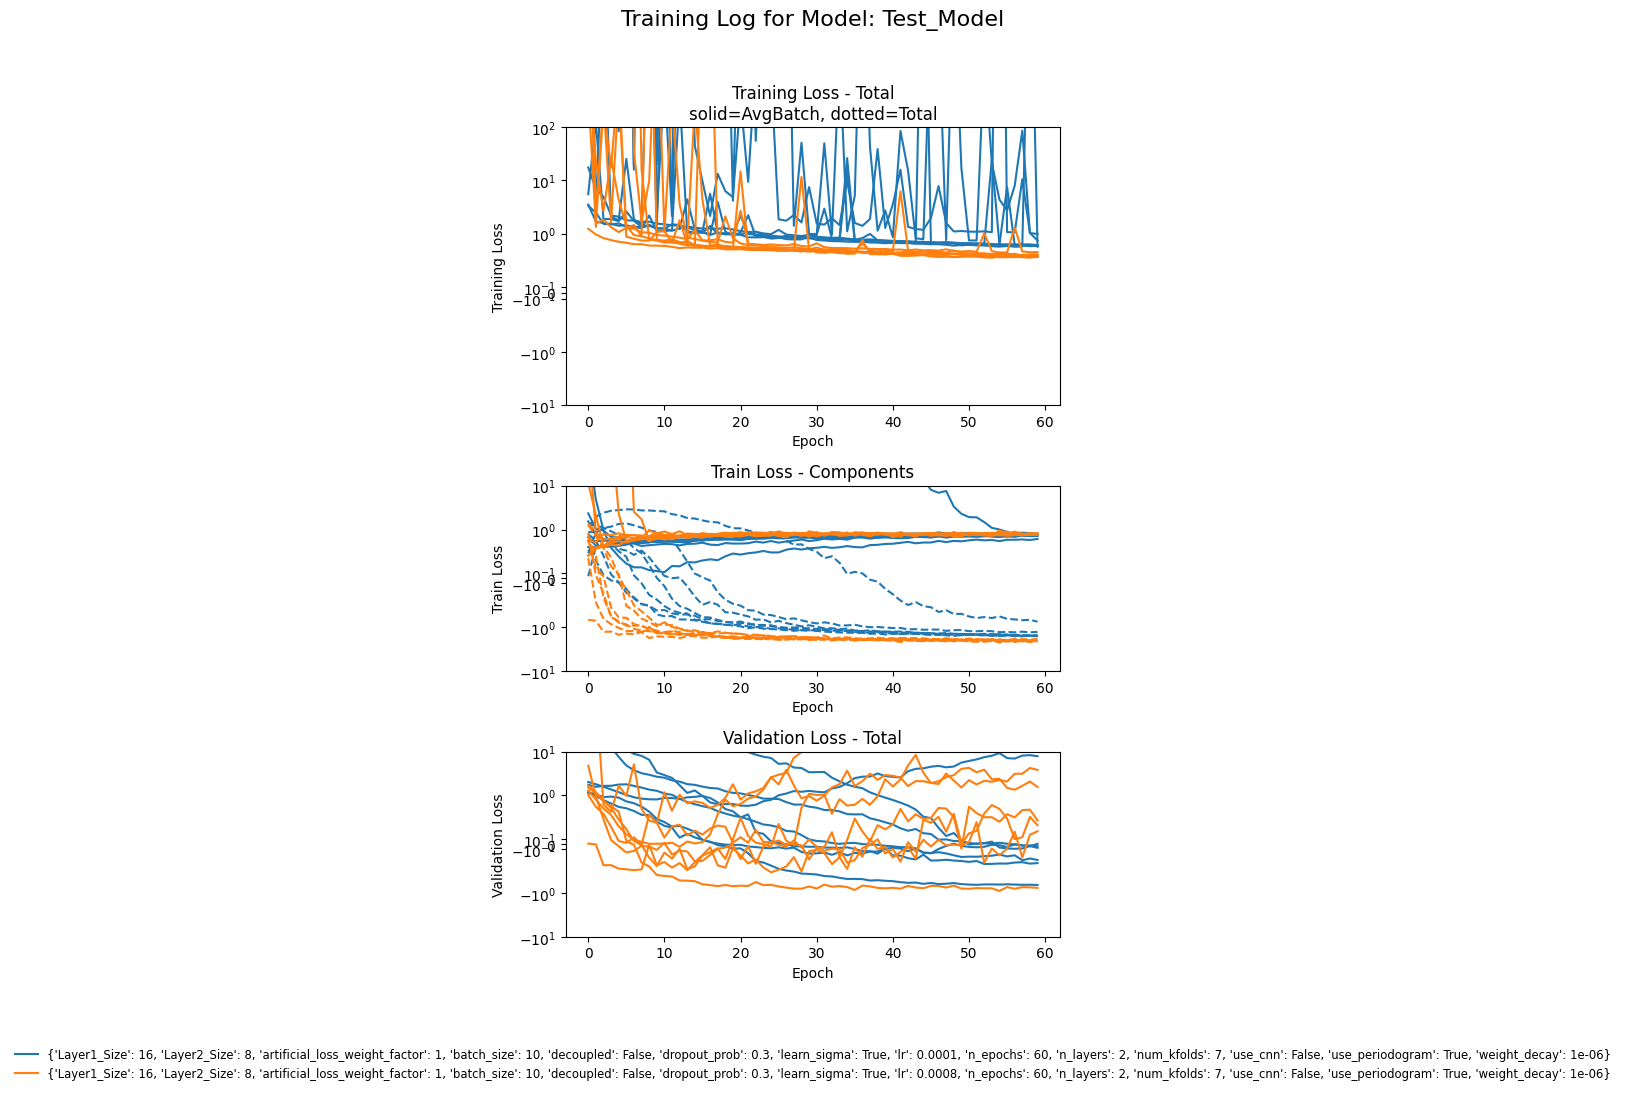

In [17]:

# First Simply Plot the Loss Vs. Epoch
plot_trainval_loss_evolution(all_runs_log)

Test_Model
Run_id 0
Run_id 1
      train_Loss = -0.858771; epoch = 49
      mean_batch_loss = 0.562864; epoch = 49
      train_Loss = -0.858771; epoch = 49
      valid_Loss = -0.290062; epoch = 36
      train_errLoss = 0.410515; epoch = 1
      valid_errLoss = 0.453871; epoch = 4
      train_sigmaLoss = -1.665598; epoch = 49
      valid_sigmaLoss = -1.612220; epoch = 49
Run_id 2
Run_id 3
Run_id 4
Run_id 5
Run_id 6
      train_Loss = 0.137314; epoch = 49
      mean_batch_loss = 1.186310; epoch = 46
      train_Loss = 0.137314; epoch = 49
NaNs detected in data, careful.
      valid_Loss = nan; epoch = 0
      train_errLoss = 0.576680; epoch = 43
      valid_errLoss = 0.406080; epoch = 13
      train_sigmaLoss = -0.647229; epoch = 48
      valid_sigmaLoss = -0.675688; epoch = 49
Run_id 7
Run_id 8
Run_id 9
Run_id 10
Run_id 11
      train_Loss = 1.773373; epoch = 49
      mean_batch_loss = 2.115859; epoch = 46
      train_Loss = 1.773373; epoch = 49
      valid_Loss = 1.661589; epoch = 49
 

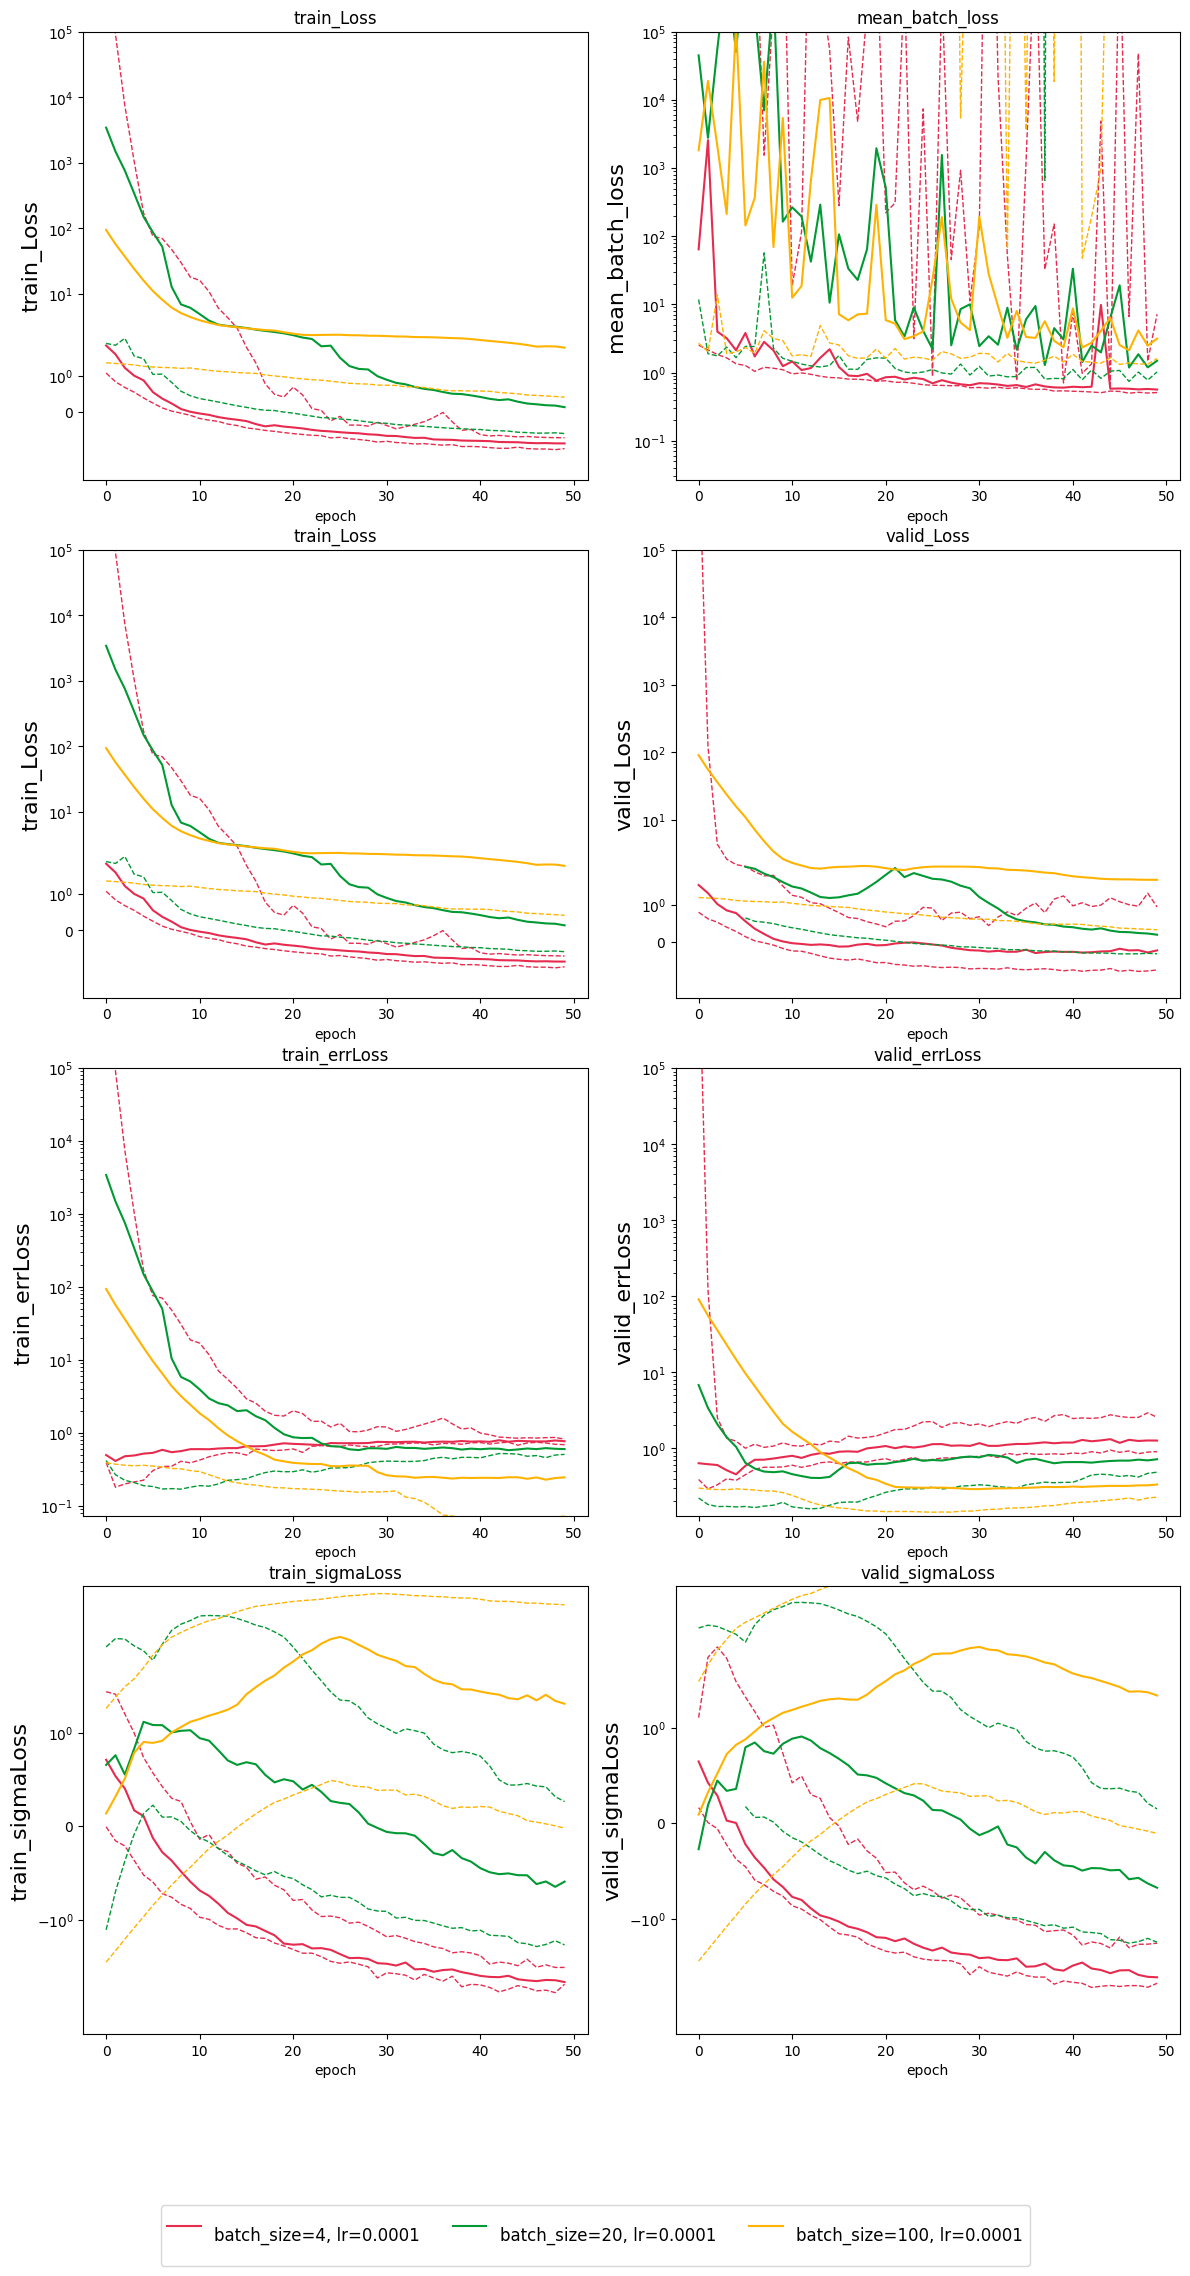

Test_Model
Run_id 0
Run_id 1
      train_RMSE = 0.490336; epoch = 48
      valid_RMSE = 0.564718; epoch = 43
      train_MAE = 0.353508; epoch = 49
      valid_MAE = 0.432019; epoch = 43
      train_median_sigma = 0.424600; epoch = 46
      valid_median_sigma = 0.451649; epoch = 48
      train_mean_sigma = 0.477254; epoch = 49
      valid_mean_sigma = 0.474555; epoch = 49
Run_id 2
Run_id 3
Run_id 4
Run_id 5
Run_id 6
      train_RMSE = 0.604076; epoch = 49
      valid_RMSE = 0.639500; epoch = 49
      train_MAE = 0.427123; epoch = 49
      valid_MAE = 0.497087; epoch = 49
      train_median_sigma = 0.678700; epoch = 49
      valid_median_sigma = 0.724200; epoch = 49
      train_mean_sigma = 1.139724; epoch = 49
      valid_mean_sigma = 0.825348; epoch = 49
Run_id 7
Run_id 8
Run_id 9
Run_id 10
Run_id 11
      train_RMSE = 0.913005; epoch = 49
      valid_RMSE = 0.884439; epoch = 49
      train_MAE = 0.661984; epoch = 49
      valid_MAE = 0.686166; epoch = 49
      train_median_sigma = 0.

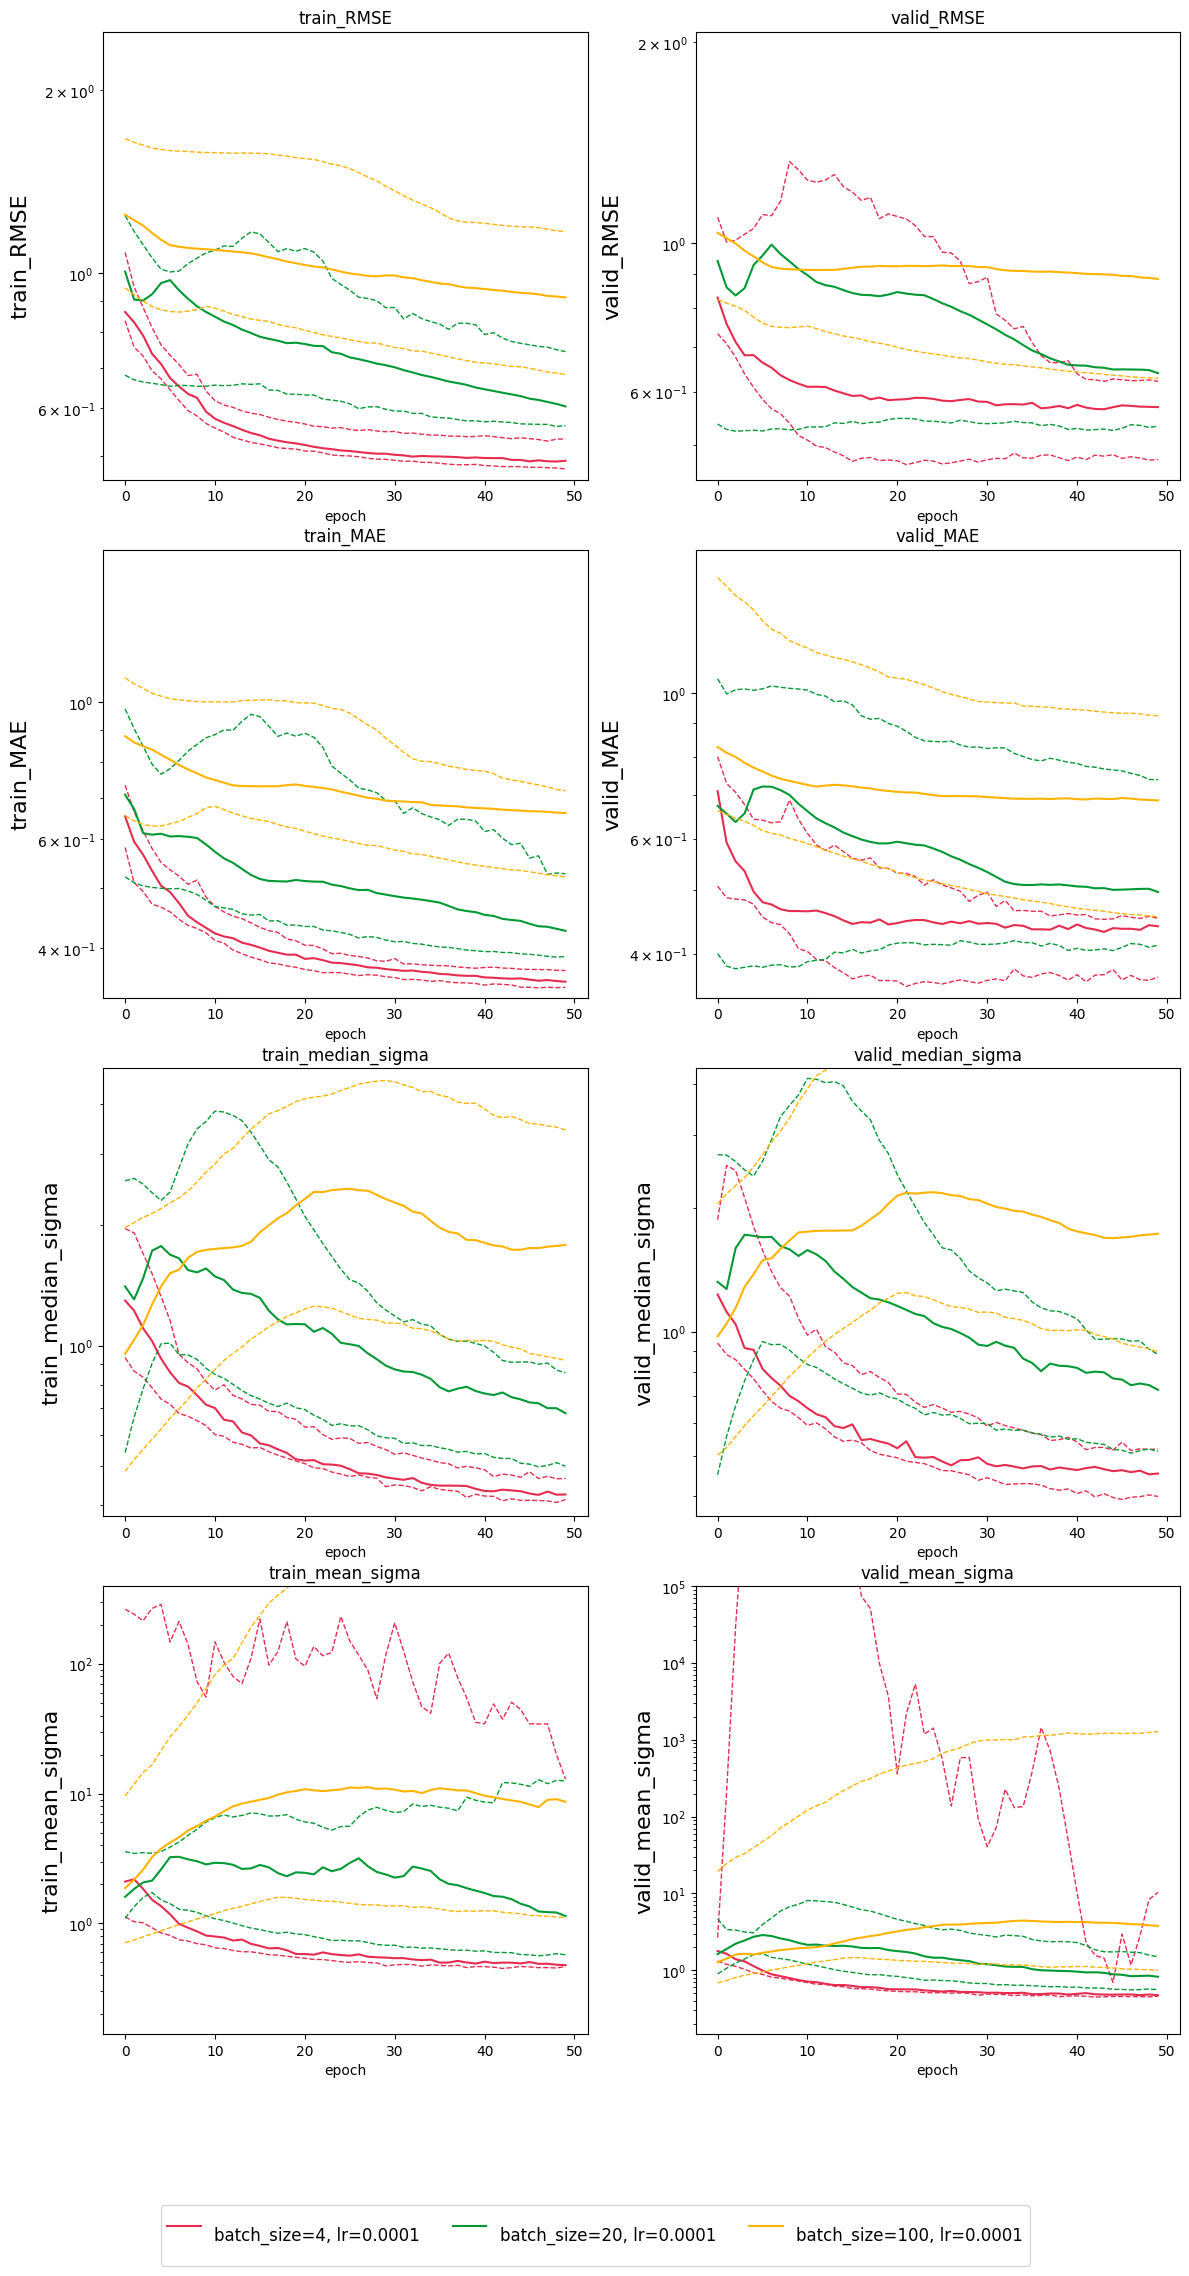

Test_Model
Run_id 0
Run_id 1
      train_Coverage68 = 0.074994; epoch = 42
      valid_Coverage68 = 0.000212; epoch = 28
      train_Coverage95 = 0.024457; epoch = 42
      valid_Coverage95 = 0.000530; epoch = 39
      train_CRPS = 0.247424; epoch = 49
      valid_CRPS = 0.306967; epoch = 41
Run_id 2
Run_id 3
Run_id 4
Run_id 5
Run_id 6
      train_Coverage68 = 0.159600; epoch = 49
      valid_Coverage68 = 0.099152; epoch = 49
      train_Coverage95 = 0.004492; epoch = 1
      valid_Coverage95 = 0.011268; epoch = 1
      train_CRPS = 0.405633; epoch = 49
NaNs detected in data, careful.
      valid_CRPS = nan; epoch = 0
Run_id 7
Run_id 8
Run_id 9
Run_id 10
Run_id 11
      train_Coverage68 = 0.008308; epoch = 0
      valid_Coverage68 = 0.029507; epoch = 0
      train_Coverage95 = 0.000059; epoch = 3
      valid_Coverage95 = 0.000704; epoch = 3
      train_CRPS = 0.825659; epoch = 0
      valid_CRPS = 0.609671; epoch = 3
Run_id 12
Run_id 13
Run_id 14


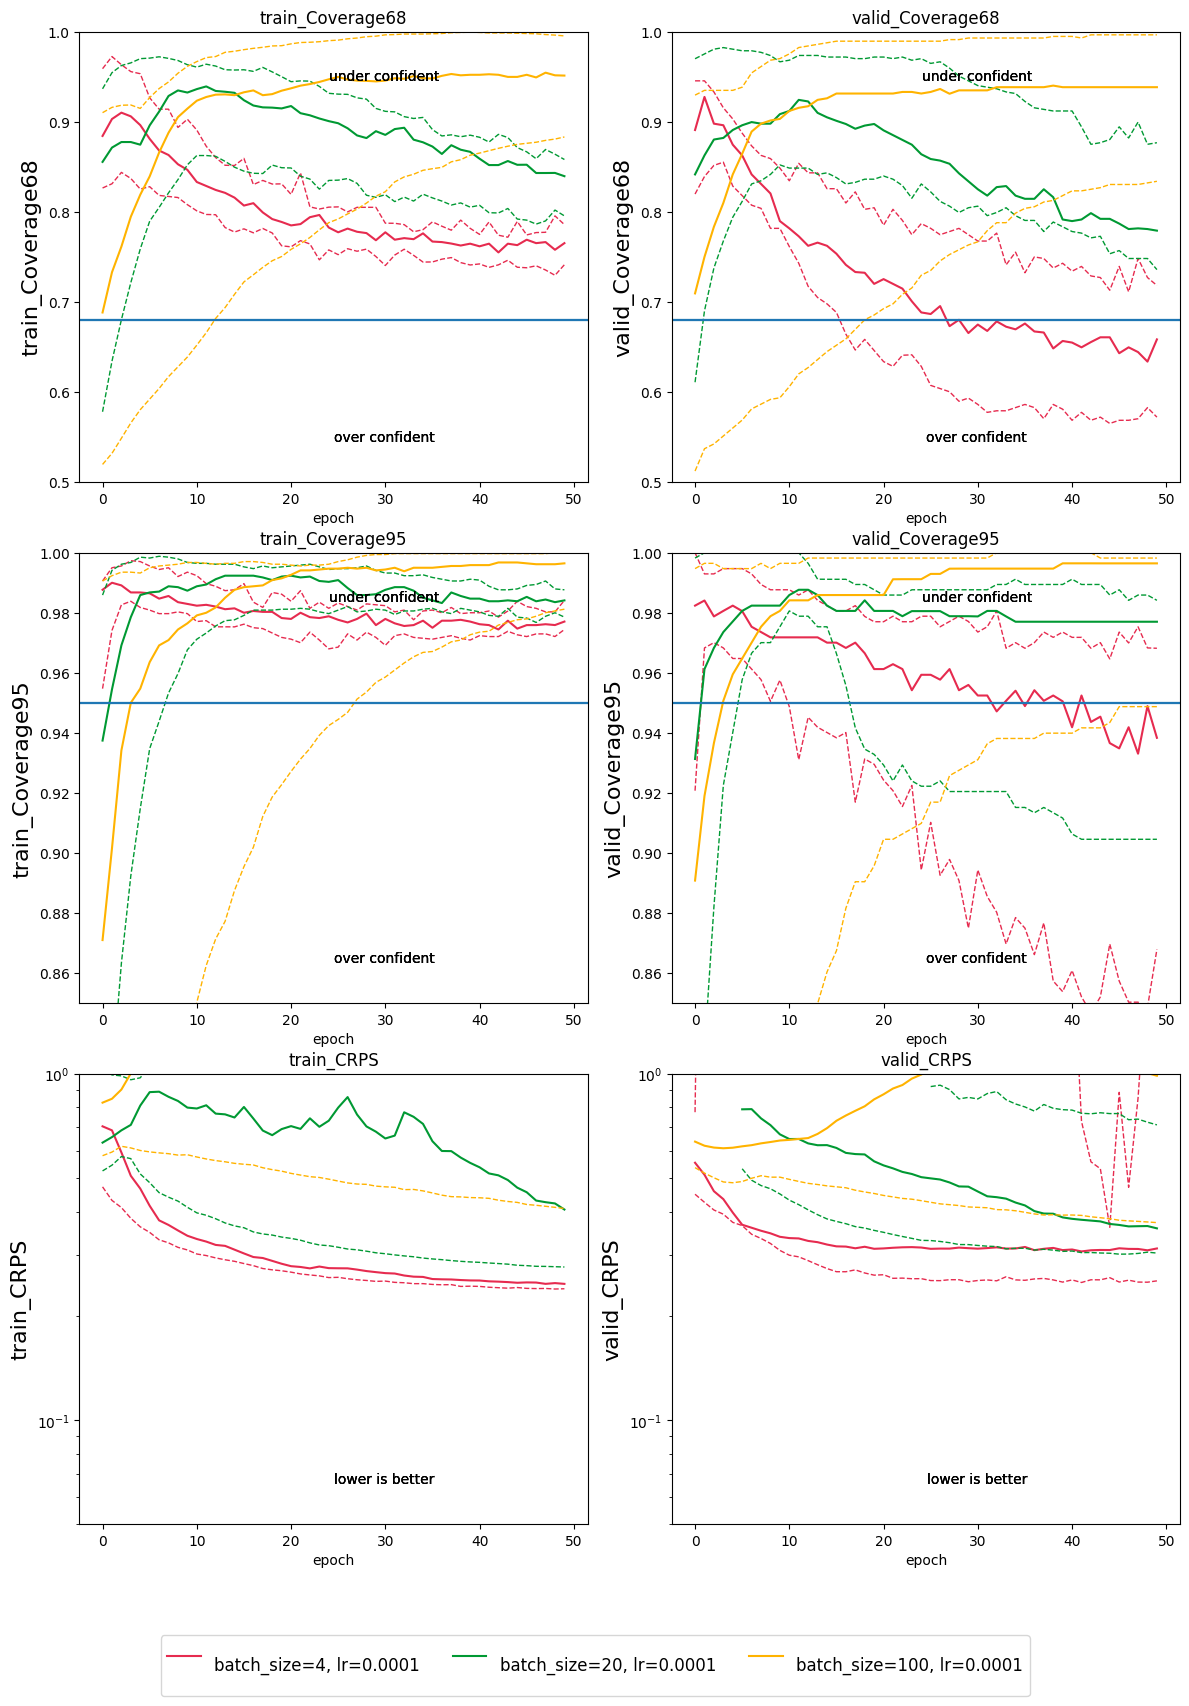

In [38]:

# between dropout prob of .2 and .4, .2 is better but .4 looks more stable.
plot_all_metric_evolution(all_runs_log, 
                           specific_lr=1e-4, 
                           #specific_batchsize=20, 
                           #specific_dropout=0.3,
                           use_minmax_spread=True
                          )

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# ==========================================================
# Utility helpers
# ==========================================================

def smooth_curve(y, window=5):
    """
    Moving average smoothing with edge handling: only average available points.
    """
    y = np.array(y)
    n = len(y)
    if n == 0:
        return y
    smoothed = np.zeros_like(y)
    for i in range(n):
        start = max(0, i - window // 2)
        end = min(n, i + window // 2 + 1)
        smoothed[i] = np.mean(y[start:end])
    return smoothed


def average_kfold_logs(run_entry):
    """Average metrics over all k-folds in a single run."""
    logs = [v['log'] for k, v in run_entry.items() if isinstance(k, int)]
    if not logs:
        return {}
    keys = logs[0].keys()
    avg_log = {}
    for key in keys:
        arrays = [np.array(log[key]) for log in logs if len(log[key]) > 0]
        if arrays:
            avg_log[key] = np.nanmean(np.stack(arrays), axis=0)
        else:
            avg_log[key] = np.array([])
    return avg_log

# ==========================================================
# Ranking function
# ==========================================================

def rank_models_by_validation(all_runs_log, smooth_window=5,
                              weights={'loss':2, 'cov68':1, 'cov95':1, 'err1':1, 'err2':1},
                              err_metric1='valid_RMSE', err_metric2='valid_MAE',
                              color_by='rank'):
    """
    Find best epoch per model/run using smoothed validation loss,
    compute composite score using loss, coverage, and error metrics,
    then rank models and plot summary.
    """

    records = []

    for model_name, runs in all_runs_log.items():
        for run_id, run_data in runs.items():
            params = run_data['params']
            avg_log = average_kfold_logs(run_data)

            if not avg_log or 'valid_Loss' not in avg_log:
                print(f"⚠️ Missing log data for {model_name} run {run_id}")
                continue

            # Smooth metrics
            val_loss = smooth_curve(avg_log['valid_Loss'], smooth_window)
            cov68 = smooth_curve(avg_log['valid_Coverage68'], smooth_window)
            cov95 = smooth_curve(avg_log['valid_Coverage95'], smooth_window)
            err1 = smooth_curve(avg_log.get(err_metric1, np.zeros_like(val_loss)), smooth_window)
            err2 = smooth_curve(avg_log.get(err_metric2, np.zeros_like(val_loss)), smooth_window)
            epochs = np.arange(len(val_loss))

            # Find best epoch
            best_epoch = np.nanargmin(val_loss)
            best_loss = val_loss[best_epoch]
            best_cov68 = cov68[best_epoch]
            best_cov95 = cov95[best_epoch]
            best_err1 = err1[best_epoch]
            best_err2 = err2[best_epoch]

            # Compute a composite score
            score = (
                weights['loss'] * best_loss +
                weights['cov68'] * abs(best_cov68 - 0.68) +
                weights['cov95'] * abs(best_cov95 - 0.95) +
                weights['err1'] * best_err1 +
                weights['err2'] * best_err2
            )

            records.append({
                'model': model_name,
                'run_id': run_id,
                'params': params,
                'best_epoch': best_epoch,
                'best_loss': best_loss,
                'best_cov68': best_cov68,
                'best_cov95': best_cov95,
                'best_err1': best_err1,
                'best_err2': best_err2,
                'score': score
            })

    df = pd.DataFrame(records)
    if df.empty:
        print("No valid data found.")
        return df

    df_sorted = df.sort_values('score', ascending=True).reset_index(drop=True)
    df_sorted['rank'] = np.arange(1, len(df_sorted) + 1)
    
    print("=== Ranked Models ===")
    for _, row in df_sorted.iterrows():
        print(f"Rank {row['rank']:02d}: {row['model']} "
              f"(score={row['score']:.4f}, epoch={row['best_epoch']})")
        print(f"     params: {row['params']}")
    print("============================================\n")

    # plot_ranked_model_metrics(all_runs_log, df_sorted,
    #                           err_metric1, err_metric2,
    #                           weights=weights,
    #                           color_by=color_by,
    #                           smooth_window=smooth_window)
    return df_sorted


# ==========================================================
# Plotting function
# ==========================================================
def plot_ranked_model_metrics(all_runs_log, df_sorted, err_metric1, err_metric2,
                              weights=None, smooth_window=5, color_by='rank',
                             range_n_models=[0, 1e20],
                              err1_lims=None, err2_lims=None, loss_lims=None,
                              
                             log_colorbar=False):
    """
    Plot 6 metrics for ranked models:
    1) Weighted summed evaluation metric (symlog)
    2) Validation loss (symlog)
    3) Coverage68
    4) Coverage95
    5) Error metric 1
    6) Error metric 2

    Each model colored by rank or score. Best epoch is marked on all plots.
    """

    if weights is None:
        weights = {'loss':2, 'cov68':1, 'cov95':1, 'err1':1, 'err2':1}

    cmap = plt.colormaps.get_cmap('RdYlGn_r')  # green=good, red=bad


    # CLEAN MODELS for Nan and Outliers
    valid_mask = ~df_sorted[color_by].isna()
    df_sorted = df_sorted[valid_mask].copy()

    #  Remove extreme outliers (>2 orders of magnitude larger than median), Compute median of the remaining valid values
    median_val = np.median(df_sorted[color_by].values)
    outlier_mask = df_sorted[color_by] <= median_val * 1e2
    df_sorted = df_sorted[outlier_mask].copy()
    
    # Extract the cleaned color values
    values = df_sorted[color_by].values


    
    if range_n_models[0] >= np.nanmin(values):
        color_norm_min = range_n_models[0]
    else:
        color_norm_min = np.nanmin(values)
        
    if range_n_models[1] < np.nanmax(values):
        color_norm_max = range_n_models[1]
    else:
        color_norm_max = np.nanmax(values)
    print('Color MinMax:', color_norm_min, color_norm_max)
    norm = Normalize(vmin=color_norm_min, vmax=color_norm_max)
    sm = ScalarMappable(norm=norm, cmap=cmap)

    fig, axs = plt.subplots(3, 2, figsize=(14, 12))
    ax_metric, ax_loss, ax_cov68, ax_cov95, ax_err1, ax_err2 = axs.flatten()
    color_label = 'Model Rank' if color_by == 'rank' else 'Composite Score'

    for i, row in df_sorted.iterrows():
        if i < range_n_models[0] or i >= range_n_models[1]: #Only Plot models in the specified range
            continue
            
        model = row['model']
        run_id = row['run_id']
        best_epoch = row['best_epoch']
        avg_log = average_kfold_logs(all_runs_log[model][run_id])
        if not avg_log or 'valid_Loss' not in avg_log:
            continue


        

        color_value = row[color_by]     # guaranteed correct
        color = cmap(norm(color_value))
        
        epochs = np.arange(len(avg_log['valid_Loss']))

        val_loss_smooth = smooth_curve(avg_log['valid_Loss'], smooth_window)
        
        #if np.nanmin(val_loss_smooth) > 5:
        #    continue

           #dont need to smooth the actual metrics 
        #cov68_smooth = smooth_curve(avg_log['valid_Coverage68'], smooth_window)
        #cov95_smooth = smooth_curve(avg_log['valid_Coverage95'], smooth_window)
        #err1_smooth  = smooth_curve(avg_log.get(err_metric1, np.zeros_like(val_loss_smooth)), smooth_window)
        #err2_smooth  = smooth_curve(avg_log.get(err_metric2, np.zeros_like(val_loss_smooth)), smooth_window)
        cov68_smooth = avg_log['valid_Coverage68']
        cov95_smooth = avg_log['valid_Coverage95']
        err1_smooth  = avg_log.get(err_metric1, np.zeros_like(val_loss_smooth))
        err2_smooth  = avg_log.get(err_metric2, np.zeros_like(val_loss_smooth))

        # Weighted summed evaluation metric
        summed_metric = (
            weights.get('loss',1) * val_loss_smooth +
            weights.get('cov68',1) * abs(cov68_smooth - 0.68) +
            weights.get('cov95',1) * abs(cov95_smooth - 0.95) +
            weights.get('err1',1) * err1_smooth +
            weights.get('err2',1) * err2_smooth
        )

        # --- Plots ---
        for ax, metric_data in zip(
            [ax_metric, ax_loss, ax_cov68, ax_cov95, ax_err1, ax_err2],
            [summed_metric, val_loss_smooth, cov68_smooth, cov95_smooth, err1_smooth, err2_smooth]
        ):
            ax.plot(epochs, metric_data, color=color)
            if i==0:
                ax.scatter(best_epoch, metric_data[best_epoch], color='magenta', edgecolor='k', s=40, zorder=3)
            else:
                ax.scatter(best_epoch, metric_data[best_epoch], color=color, edgecolor='k', s=40, zorder=3)

        # Set symlog axes for relevant plots
        ax_metric.set_yscale('symlog', linthresh=1e-2)
        ax_loss.set_yscale('symlog')
        ax_loss.set_ylim(top=1e4)

        # Add horizontal reference lines for coverage
        ax_cov68.axhline(0.68, color='k', linestyle=':', lw=1)
        ax_cov95.axhline(0.95, color='k', linestyle=':', lw=1)

    # --- Labels and formatting ---
    ax_metric.set_title("Weighted Summed Evaluation Metric vs Epoch (symlog)")
    ax_loss.set_title("Validation Loss (symlog) vs Epoch")
    ax_cov68.set_title("Coverage68 vs Epoch")
    ax_cov95.set_title("Coverage95 vs Epoch")
    ax_err1.set_title(f"{err_metric1} vs Epoch")
    ax_err2.set_title(f"{err_metric2} vs Epoch")

    if err1_lims is not None:
        ax_err1.set_ylim(err1_lims)
    if err2_lims is not None:
        ax_err2.set_ylim(err2_lims)
    if loss_lims is not None:
        ax_loss.set_ylim(loss_lims)


    for ax in [ax_metric, ax_loss, ax_cov68, ax_cov95, ax_err1, ax_err2]:
        ax.set_xlabel("Epoch")
        ax.grid(True, alpha=0.3)

    # --- Colorbar without overlapping ---
    import matplotlib.colors as mcolors
    
    if log_colorbar:
        norm = mcolors.LogNorm(vmin=color_norm_min, vmax=color_norm_max)
    else:
        norm = mcolors.Normalize(vmin=color_norm_min, vmax=color_norm_max)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cbar = fig.colorbar(sm, ax=axs.ravel(), location='right', fraction=0.03, pad=0.02)
    cbar.set_label(color_label)
    
    fig.tight_layout(rect=[0, 0, 0.95, 1])  # leave space on the right for colorbar
    plt.show()


/var/folders/35/rfpfvg753mv5n8d8j12w14j80000gn/T/ipykernel_18002/3614138433.py:85: RuntimeWarning: invalid value encountered in multiply
  weights['loss'] * best_loss +


=== Ranked Models ===
Rank 01: Test_Model (score=0.2836, epoch=32)
     params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0001, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
Rank 02: Test_Model (score=0.2937, epoch=23)
     params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 20, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0009, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_periodogram': True, 'weight_decay': 1e-06}
Rank 03: Test_Model (score=0.3034, epoch=6)
     params: {'Layer1_Size': 16, 'Layer2_Size': 8, 'artificial_loss_weight_factor': 1, 'batch_size': 4, 'decoupled': False, 'dropout_prob': 0.3, 'learn_sigma': True, 'lr': 0.0009, 'n_epochs': 50, 'n_layers': 2, 'num_kfolds': 7, 'use_cnn': False, 'use_peri

/var/folders/35/rfpfvg753mv5n8d8j12w14j80000gn/T/ipykernel_18002/3614138433.py:222: RuntimeWarning: invalid value encountered in multiply
  weights.get('loss',1) * val_loss_smooth +
/var/folders/35/rfpfvg753mv5n8d8j12w14j80000gn/T/ipykernel_18002/3614138433.py:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 0.95, 1])  # leave space on the right for colorbar


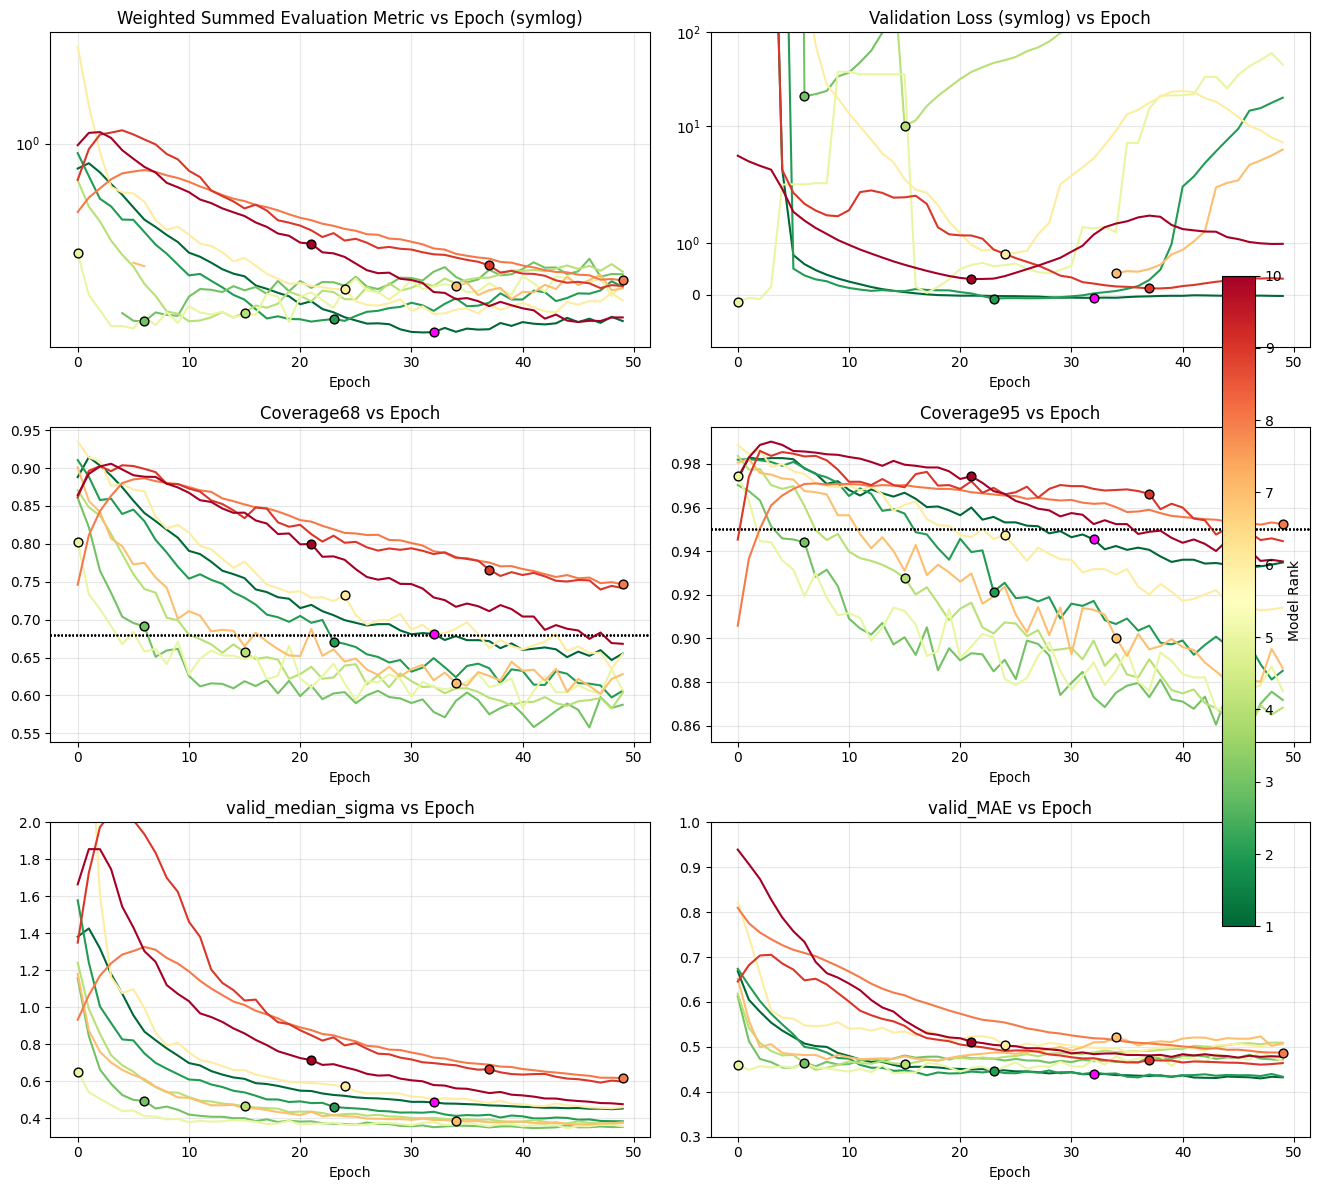

In [34]:


metric_weights = {'loss':0, 'cov68':1, 'cov95':1, 'err1':3e-1, 'err2':3e-1}
err_metric1 = 'valid_median_sigma'
err_metric2 = 'valid_MAE'
smooth_window = 7
df_ranked = rank_models_by_validation(all_runs_log, smooth_window=smooth_window, 
                                      weights=metric_weights,
                                      err_metric1=err_metric1, err_metric2=err_metric2)


kwargs = dict(range_n_models=[0, 10], color_by='rank', 
              err1_lims=[0.3, 2], err2_lims=[0.3, 1], loss_lims=[-1, 100],
             log_colorbar=False,
             )

plot_ranked_model_metrics(all_runs_log, df_ranked, err_metric1, err_metric2,
                              weights=metric_weights, smooth_window=smooth_window, **kwargs)



In [35]:
# ============================================================
# EXPORT BEST MODEL PARAMETERS
# ============================================================

# Extract best model (rank 1 = row 0)
best_model_info = df_ranked.iloc[0]
best_params = best_model_info['params']
best_epoch = best_model_info['best_epoch']

# Display results
print("\n" + "="*70)
print("✅ BEST MODEL IDENTIFIED")
print("="*70)
print(f"Model Name:      {best_model_info['model']}")
print(f"Run ID:          {best_model_info['run_id']}")
print(f"Rank:            {best_model_info['rank']}")
print(f"Composite Score: {best_model_info['score']:.4f}")
print(f"Best Epoch:      {best_epoch}")
print(f"\nValidation Metrics @ Best Epoch:")
print(f"  Loss:          {best_model_info['best_loss']:.4f}")
print(f"  Coverage@68%:  {best_model_info['best_cov68']:.4f} (target: 0.68)")
print(f"  Coverage@95%:  {best_model_info['best_cov95']:.4f} (target: 0.95)")
print(f"  {err_metric1}: {best_model_info['best_err1']:.4f}")
print(f"  {err_metric2}: {best_model_info['best_err2']:.4f}")

print(f"\nHyperparameters:")
for key, value in best_params.items():
    print(f"  {key:30s} = {value}")
print("="*70)

# Export to file
import pickle
import os

# Ensure TempFiles directory exists
os.makedirs(temp_files_path, exist_ok=True)

export_data = {
    'params': best_params,
    'best_epoch': best_epoch,
    'model_name': best_model_info['model'],
    'run_id': best_model_info['run_id'],
    'composite_score': best_model_info['score'],
    'metrics': {
        'loss': best_model_info['best_loss'],
        'cov68': best_model_info['best_cov68'],
        'cov95': best_model_info['best_cov95'],
        'err1': best_model_info['best_err1'],
        'err2': best_model_info['best_err2'],
        'err_metric1_name': err_metric1,
        'err_metric2_name': err_metric2
    },
    'ranking_info': {
        'metric_weights': metric_weights,
        'smooth_window': smooth_window,
        'total_models_evaluated': len(df_ranked)
    }
}

output_file = temp_files_path + 'best_model_params.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(export_data, f)

print(f"\n✅ Best model parameters saved to: {output_file}")
print(f"   Ready for use in 2_TrainBestModel.ipynb")
print("="*70 + "\n")


✅ BEST MODEL IDENTIFIED
Model Name:      Test_Model
Run ID:          1
Rank:            1
Composite Score: 0.2836
Best Epoch:      32

Validation Metrics @ Best Epoch:
  Loss:          -0.0577
  Coverage@68%:  0.6792 (target: 0.68)
  Coverage@95%:  0.9446 (target: 0.95)
  valid_median_sigma: 0.4850
  valid_MAE: 0.4399

Hyperparameters:
  Layer1_Size                    = 16
  Layer2_Size                    = 8
  artificial_loss_weight_factor  = 1
  batch_size                     = 4
  decoupled                      = False
  dropout_prob                   = 0.3
  learn_sigma                    = True
  lr                             = 0.0001
  n_epochs                       = 50
  n_layers                       = 2
  num_kfolds                     = 7
  use_cnn                        = False
  use_periodogram                = True
  weight_decay                   = 1e-06

✅ Best model parameters saved to: /Users/howard_willard/Desktop/TESS_Cluster_Age_ML/GaussianNN_CGW/Model_Pipeline/T

# MCMC Dropout Figs

In [ ]:
# TRY MCMC DROPOUT
import torch
import matplotlib.pyplot as plt

def enable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()

def disable_dropout(model):
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.eval()

def visualize_mc_dropout(model, X, X_period, num_samples=100, target=None):
    """
    Runs MC dropout and visualizes prediction distribution and uncertainties.
    
    Assumes the model returns two tensors per input:
    - mean prediction: shape (batch_size, ...)
    - predicted std/uncertainty: shape (batch_size, ...)
    
    Arguments:
    - model: a PyTorch model
    - input_tensor: shape (batch_size, input_dim)
    - num_samples: number of MC dropout samples
    - target: optional ground-truth tensor for comparison
    """
    model.eval()
    enable_dropout(model)
    
    pred_list = []
    sigma_list = []

    with torch.no_grad():
        for _ in range(num_samples):
            pred, sigma = model( X, X_period)
            pred_list.append(pred.unsqueeze(0))    # [1, batch_size, ...]
            sigma_list.append(sigma.unsqueeze(0))  # [1, batch_size, ...]

    preds = torch.cat(pred_list, dim=0)   # [num_samples, batch_size, ...]
    sigmas = torch.cat(sigma_list, dim=0) # [num_samples, batch_size, ...]

    mean_pred = preds.mean(dim=0)
    std_pred = preds.std(dim=0)
    mean_sigma = sigmas.mean(dim=0)

    # Plot for batch_size = 1 (or pick one example if batched)
    idx = 100
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.hist(preds[:, idx].cpu().numpy(), bins=30, alpha=0.7, label="MC Predictions")
    ax.axvline(mean_pred[idx].item(), color='k', linestyle='--', label='MC Mean')
    ax.axvspan(mean_pred[idx].item() - std_pred[idx].item(),
               mean_pred[idx].item() + std_pred[idx].item(),
               color='blue', alpha=0.2, label='MC Std Dev')
    
    ax.axvspan(mean_pred[idx].item() - mean_sigma[idx].item(),
               mean_pred[idx].item() + mean_sigma[idx].item(),
               color='orange', alpha=0.2, label='Predicted Sigma')

    if target is not None:
        ax.axvline(target[idx].item(), color='red', label='Target', linewidth=2)

    ax.set_title("MC Dropout Prediction Distribution")
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Frequency")
    ax.legend()
    plt.tight_layout()
    plt.show()


    # Disable dropouts:
    model.eval()
    return



print('\n\n\n## MCMC Dropout')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    ##, X_period, Y = model_train_data_statistics[i], model_train_data_periodogram[i], model_train_data_Y[i] 
    X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    #X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 
    
    for run_id in all_runs_log[model_name].keys():
        #if (config_dict['batch_size']==1000) and (config_dict['lr']<1e-3):
        model = all_runs_log[model_name][run_id][4]['model']
        #flattened_name_list.append(str(config_dict))
        #SumStats_list.append(SummaryStats(model,  X_test, y_test))
        visualize_mc_dropout(model, X, X_period, num_samples=100, target=Y)



In [ ]:
all_runs_log[model_name][run_id][0].keys()

In [ ]:
import torch
import matplotlib.pyplot as plt

def visualize_mc_dropout_batch(model, X, X_period, num_samples=1000, targets=None, sort_x=False):
    """
    Run MC Dropout on a batch of inputs and visualize prediction mean + uncertainty.
    
    Assumes model returns (prediction, predicted_sigma).
    
    Parameters:
    - model: PyTorch model
    - input_tensor: Tensor of shape [batch_size, input_dim]
    - num_samples: number of stochastic forward passes
    - targets: optional tensor of shape [batch_size]
    - sort_x: if True, will sort x-axis by mean prediction
    """
    model.eval()
    enable_dropout(model)

    pred_list = []
    sigma_list = []

    with torch.no_grad():
        for _ in range(num_samples):
            pred, sigma = model(X, X_period)
            pred_list.append(pred.unsqueeze(0))    # [1, batch_size]
            sigma_list.append(sigma.unsqueeze(0))  # [1, batch_size]

    preds = torch.cat(pred_list, dim=0)   # [num_samples, batch_size]
    sigmas = torch.cat(sigma_list, dim=0) # [num_samples, batch_size]

    mean_pred = preds.mean(dim=0).squeeze(-1).cpu().numpy() # Mean all the predictions (for each point)
    std_pred = preds.std(dim=0).squeeze(-1).cpu().numpy()   # Std of all the predicitons (for each point)
    mean_sigma = sigmas.mean(dim=0).squeeze(-1).cpu().numpy() # Avg model uncertainty from each prediction (for each point)

    x = torch.arange(len(mean_pred))  # default x-axis = index

    if sort_x and (targets is not None):
        print(type(mean_pred), type(std_pred), type(mean_sigma), type(x), type(targets))
        print(np.shape(mean_pred), np.shape(std_pred), np.shape(mean_sigma), np.shape(x), np.shape(targets))

        targets = targets.squeeze(-1).cpu().numpy()
        sort_idx = targets.argsort()
        targets = targets[sort_idx]

        mean_pred = mean_pred[sort_idx]
        std_pred = std_pred[sort_idx]
        mean_sigma = mean_sigma[sort_idx]
        # x = x.squeeze(-1).cpu().numpy()
        # print(x)
        # #x = x[sort_idx]
    
        #if targets is not None:
        print(type(mean_pred), type(std_pred), type(mean_sigma), type(x), type(targets))
        print(np.shape(mean_pred), np.shape(std_pred), np.shape(mean_sigma), np.shape(x), np.shape(targets))

    # Plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(x, mean_pred, yerr=std_pred, fmt='o', label='MC Mean ± Std (Epistemic)', alpha=0.7, ms=0.01)

    # Optional predicted uncertainty
    plt.fill_between(x, mean_pred - mean_sigma, mean_pred + mean_sigma, 
                     color='orange', alpha=0.2, label='Predicted Sigma (Aleatoric)')

    if targets is not None:
        plt.plot(x, targets, 'r--', label='Target')

    plt.xlabel("Data Point Index" + (" (sorted)" if sort_x else ""))
    plt.ylabel("Prediction")
    plt.title("MC Dropout Predictions with Uncertainty")
    plt.legend()
    plt.tight_layout()
    plt.ylim(-2, 2.5)
    plt.show()

    # Disable dropouts:
    model.eval()
    return




print('\n\n\n## MCMC Dropout')
SumStats_list = []    
flattened_name_list = []
for i, model_name in enumerate(model_names):
    #X, X_period, Y = model_train_data_statistics[i], model_train_data_periodogram[i], model_train_data_Y[i] 
    X, X_period, Y = model_test_data_statistics[i], model_test_data_periodogram[i], model_test_data_Y[i] 
    #X, X_period, Y = model_valid_data_statistics[i], model_valid_data_periodogram[i], model_valid_data_Y[i] 
    
    for run_id in all_runs_log[model_name].keys():
        model = all_runs_log[model_name][run_id][0]['model']
        visualize_mc_dropout_batch(model, X, X_period, num_samples=100, targets=Y, sort_x=True)



# Retrain the best model params on full set

In [ ]:
#all_runs_log['Test_Model'][run_id].keys()

In [ ]:

import time

#Define which datasets you wish to use. 
#Here there is just one, but the code could handle more if you specifiy different ones here.

summary_stat_dims = [X_train.shape[1]]
periodogram_dims = [period_train.shape[1]]

model_train_data_statistics  = [X_train]
model_train_data_periodogram = [period_train]
model_train_data_Y           = [y_train]

model_test_data_statistics   = [X_test]
model_test_data_periodogram  = [period_test]
model_test_data_Y            = [y_test]

model_names = ['Test_Model']


#### Define the model Hyperparameters. A grid of all cominations will be run.
params = {
'use_periodogram': [True], # If True, Runs the model with the periodigram data
'use_cnn': [False],        # If True, Runs the periodigram data using 
'decoupled': [False],
'learn_sigma': [True],
    
'n_layers': [2],
'Layer1_Size': [32],
'Layer2_Size': [16],

'dropout_prob': [0.3],
'lr':   [1e-3],    # np.logspace(-2, -3, 2), #[1e-2, 1e-3, 1e-4], np.logspace(-2, -4, 5)
'batch_size': [2, 16], #np.logspace(3, 4, 2), #

'n_epochs': [75],
'artificial_loss_weight_factor': [1],
'weight_decay': [1e-6],
'num_kfolds': [5]
}

# self,
# summary_dim,              # Input size for summary stats
# periodogram_dim=0,        # Input size for periodogram (only used if enabled)
# x1=64,                    # Hidden layer size
# dropout_prob=0.3,
# use_periodogram=True,
# periodogram_use_cnn=False):

empty_train_log = {
        "epoch" : [], 
        "mean_batch_loss" : [], 
        "train_errLoss" : [], 
        "train_sigmaLoss" : [], 
        "train_Loss" : [], 
        "train_MAE"  : [], 
        "train_RMSE" : [], 
        "train_median_sigma" : [], 
        "train_mean_sigma" : [], 
        "train_Coverage68" : [], 
        "train_Coverage95" : [], 
        "train_CRPS" : [], 
        "valid_errLoss" : [], 
        "valid_sigmaLoss" : [], 
        "valid_Loss" : [], 
        "valid_MAE"  : [], 
        "valid_RMSE" : [], 
        "valid_median_sigma" : [], 
        "valid_mean_sigma" : [], 
        "valid_Coverage68" : [], 
        "valid_Coverage95" : [], 
        "valid_CRPS" : [], 
}               

all_runs_log = {
    model_name: {
        run_id: {
            **{
                "params": config_dict,
            },
            **{
                k_id: {
                    "model": None,
                    "log": copy.deepcopy(empty_train_log)
                } for k_id in range(config_dict['num_kfolds'])
            }
        } for run_id, config_dict in enumerate(ParameterGrid(params))
        # SHOULD ADD THE MODEL DATA HERE, wont be memory efficient but much cleaner code for plotting and our data is small.
    } for model_name in model_names
    
}



for i, model_name in enumerate(model_names):    
    stats_dim = summary_stat_dims[i] # X_train.shape[1]
    period_dim = periodogram_dims[i] # period_train.shape[1]
    
    X_stats  = model_train_data_statistics[i]
    X_period = model_train_data_periodogram[i]
    Y        = model_train_data_Y[i]

    test_X_stats  = model_test_data_statistics[i]
    test_X_period = model_test_data_periodogram[i]
    test_Y        = model_test_data_Y[i]


    if torch.isnan(X_stats).any():
        print("Warning: NaNs detected in X_train")
    
    if torch.isnan(X_test).any():
        print("Warning: NaNs detected in X_test")
    
    run_id = 0
    for Params in ParameterGrid(params): 
        fold_id = 0
        print('  Run #', run_id, ', Params:', Params)
        model_class = DualInputNN

         # Subset the data
        training_data   = (X_stats, X_period, Y)
        validation_data = (X_stats, X_period, Y)
        
        # Initialize a new model for this fold
        model_inputs = (stats_dim, period_dim, Params['Layer1_Size'], Params['dropout_prob'], 
                        Params['use_periodogram'], Params['use_cnn'], Params['learn_sigma'])
        model = model_class(*model_inputs)
        
        # TRAIN THE MODEL
        training_log = all_runs_log[model_name][run_id][fold_id]['log'] # Points directly to the log location
        model, all_runs_log[model_name][run_id][fold_id]['log'], _ = Train_Model(model, training_data, validation_data, Params, training_log)
        all_runs_log[model_name][run_id][fold_id]['model'] = model
        
        ## Probably should add a plotting function call here to show how the different folds compare against eachother. ##
        plot_run_log(all_runs_log[model_name][run_id])
        
        run_id += 1
    
    # results_array[i, :] = test_model(model, 
    #                              X_test_tensor, y_test_tensor, 
    #                              X_test_BDATA_tensor, y_test_BDATA_tensor)

    
